# Analysis of E18 habenula cells 

___Author___ Lieke L van de Haar

The data is retrived as fastq files, trimmed and mapped using starmap. spliced, unspliced and total RNA files (coutc, coutb and coutt) are merged, renames and cleaned up on hpc.

<div class="alert alert-info">

**Notes:**
Datasets are merged in R.


</div>  

<div class="alert alert-info">
    
**Notes:**
This is the E18 wild type data from 4 plates (L1, L2, R1, R2, L1R1). they are STAR mapped and merged


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

#1scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.21.3 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1

/Users/liekevandehaar/opt/anaconda3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.6 anndata==0.7.4 umap==0.3.10 numpy==1.19.2 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.8.0 louvain==0.6.1


In [2]:
sc.settings.set_figure_params(dpi=80)

# Data loading


to load the processed data until scVELO load:

In [15]:
adata = sc.read('./data/output/April2020_E18Hb-WT_quality_filtered_clustered_velo.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 948 × 5006 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'plate', 'stage', 'group', 'well_no', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts_norm', 'umap_density_plate', 'louvain', 'velocity_clusters', 'lineages', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersi

to load the raw data and do entire processing load:

In [3]:
#import
dataset = sc.read('./data/merged_E18_Habenula.coutt_total_2.tsv').T
spliced = sc.read('./data/merged_E18_Habenula.coutt_spliced_2.tsv').T
unspliced = sc.read('./data/merged_E18_Habenula.coutt_unspliced_2.tsv').T



--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [4]:
adata = dataset
adata.layers['spliced'] = spliced.X
adata.layers['unspliced'] = unspliced.X

In [5]:
# show proportions of spliced/unspliced abundances
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.85 0.15]


AnnData object with n_obs × n_vars = 1920 × 36196 
    layers: 'spliced', 'unspliced'

# Set features, rename and print statistics

In [6]:
# Set the ERCC_ratio as a category, then remove the ERCC genes
ERCC_genes = adata.var_names.str.startswith('ERCC')
adata.obs['ERCC_genes'] = np.sum(
    adata[:, ERCC_genes].X, axis=1) / np.sum(adata.X, axis=1) #.A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts_withERCCmito'] = adata.X.sum(axis=1) #.A1



In [7]:
adata.var['fullname'] = adata.var_names
adata.var['ENS_names'] = adata.var_names.str.split('_').str[0]
adata.var['geneid'] = adata.var_names.str.split('_').str[1]
adata.var['feature'] = adata.var_names.str.split('__').str[1]
adata.var['chr'] = adata.var_names.str.split('__').str[2]

#Calculate number of genes
sc.pp.filter_cells(adata, min_genes=0)

In [8]:
print(np.median(adata.obs['n_counts_withERCCmito']), "median number of reads with ERCC per cell")
print(np.median(adata.obs['n_genes']), "median number of genes per cell")
print(np.median(adata.obs['ERCC_genes']), 'median % are ERCC_genes')

7430.6055 median number of reads with ERCC per cell
2857.0 median number of genes per cell
0.13045368 median % are ERCC_genes


In [9]:
non_ERCC_genes_list = [name for name in adata.var_names if not name.startswith('ERCC')]
adata_no_ERCC_genes = adata[:, non_ERCC_genes_list] #
adata_no_ERCC_genes

View of AnnData object with n_obs × n_vars = 1920 × 36104 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr'
    layers: 'spliced', 'unspliced'

In [10]:
#Remove ERCC genes
adata = adata_no_ERCC_genes

In [11]:
# Add number of counts
adata.obs['n_counts_with_mito'] = adata.X.sum(axis=1) #.A1

Trying to set attribute `.obs` of view, copying.


In [12]:
mito_genes = adata.var_names.str.endswith('MT')
#mito_genes = adata.var_names.str.endswith('MT')# adata.var_names["mitochondrial"]
# for each cell compute fraction of counts in mito genes vs. all genes... the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) #.A1
# add the total counts per cell as observations-annotation to adata

In [13]:
print(np.median(adata.obs['percent_mito']), "median mito_genes/total before filtering, without ERCC")

nan median mito_genes/total before filtering, without ERCC


In [14]:
#now remove the mito genes so that they dont effect downstream analysis
non_mito_genes_list = [name for name in adata.var_names if not name.endswith('MT')]
adata_no_mito_genes = adata[:, non_mito_genes_list] #mito_genes = adata.var_names.str.endswith('M')
adata_no_mito_genes

View of AnnData object with n_obs × n_vars = 1920 × 36067 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr'
    layers: 'spliced', 'unspliced'

In [15]:
adata = adata_no_mito_genes
## add number of genes
adata.obs['n_counts'] = adata.X.sum(axis=1) #.A1

Trying to set attribute `.obs` of view, copying.


In [16]:
adata.var_names = adata.var_names.str.split('_').str[1]

In [17]:
adata

AnnData object with n_obs × n_vars = 1920 × 36067 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr'
    layers: 'spliced', 'unspliced'

In [18]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [19]:
#Calculate number of genes and remove 0 values
sc.pp.filter_cells(adata, min_genes=1)
#ribo
percent_ribo = adata.var_names.str.startswith('Rp')
adata.obs['percent_ribo'] = np.sum(
    adata[:, percent_ribo].X, axis=1) / np.sum(adata.X, axis=1) #.A1


filtered out 11 cells that have less than 1 genes expressed


In [20]:
#add the % of protein coding genes 
# Once .raw is this, this can be used to calculate as well
#protein_coding_names = adata.raw.var_names[adata.raw.var['feature'] == 'protein_coding']
adata.obs['percent_coding'] = np.sum(
    adata.X[:,adata.var['feature'] == 'protein_coding'], axis=1) / np.sum(adata.X, axis=1) #.A1

#add the % of lincRNA genes 
#lincRNA_names = adata.raw.var_names[adata.raw.var['feature'] == 'lincRNA']
adata.obs['percent_lincRNA'] = np.sum(
    adata.X[:,adata.var['feature'] == 'lincRNA'], axis=1) / np.sum(adata.X, axis=1)
adata.obs['sum_lincRNA'] = np.sum(
    adata.X[:,adata.var['feature'] == 'lincRNA'], axis=1) 

#add the % of antisense genes 
#antisense_names = adata.raw.var_names[adata.raw.var['feature'] == 'antisense']
adata.obs['percent_antisense'] = np.sum(
    adata.X[:,adata.var['feature'] == 'antisense'], axis=1) / np.sum(adata.X, axis=1)
adata.obs['sum_antisense'] = np.sum(
    adata.X[:,adata.var['feature'] == 'antisense'], axis=1) 

#add the % of antisense genes 
#miRNA_names = adata.raw.var_names[adata.raw.var['feature'] == 'miRNA']
adata.obs['percent_miRNA'] = np.sum(
    adata.X[:,adata.var['feature'] == 'miRNA'], axis=1) / np.sum(adata.X, axis=1) #.A1
adata.obs['sum_miRNA'] = np.sum(
    adata.X[:,adata.var['feature'] == 'miRNA'], axis=1)

#add the % of antisense genes 
#bidirectional_promoter_lncRNA_names = adata.raw.var_names[adata.raw.var['feature'] == 'bidirectional_promoter_lncRNA']
adata.obs['percent_bidirectional_promoter_lncRNA'] = np.sum(
    adata.X[:,adata.var['feature'] == 'bidirectional_promoter_lncRNA'], axis=1) / np.sum(adata.X, axis=1) #.A1
adata.obs['sum_bidirectional_promoter_lncRNA'] = np.sum(
    adata.X[:,adata.var['feature'] == 'bidirectional_promoter_lncRNA'], axis=1) 

#snoRNA_names = adata.raw.var_names[adata.raw.var['feature'] == 'snoRNA']
adata.obs['percent_snoRNA'] = np.sum(
    adata.X[:,adata.var['feature'] == 'snoRNA'], axis=1) / np.sum(adata.X, axis=1) #.A1

#pseudogene
#misc_RNA
#sense_intronic
#sense_overlapping
#rRNA
#ribozyme
#transcribed_unprocessed_pseudogene
#transcribed_unitary_pseudogene
#transcribed_processed_pseudogene
#unprocessed_pseudogene
#unitary_pseudogene

In [21]:
#some averages...
print(np.median(adata.obs['ERCC_genes']), 'median % are ERCC_genes before filtering')
print(np.median(adata.obs['percent_mito']), "median mito_genes/total before filtering, without ERCC")
print(np.median(adata.obs['n_counts_withERCCmito']), "median number of reads with ERCC per cell")
print(np.median(adata.obs['n_counts_with_mito']), "median number of reads without ERCC per cell")
print(np.median(adata.obs['n_counts']), "median number of reads per cell, without ERCC and mito")
print(np.median(adata.obs['percent_ribo']), "median percent of ribosomal genes per cell")
print(np.median(adata.obs['n_genes']), "median number of genes per cell, without ERCC and mito")
print(np.median(adata.obs['percent_coding']), "median percent of protein_coding genes per cell")
print(np.median(adata.obs['percent_lincRNA']), "median percent of lincRNA genes per cell")
print(np.median(adata.obs['percent_antisense']), "median percent of antisense genes per cell")
print(np.median(adata.obs['percent_miRNA']), "median percent of miRNA genes per cell")
print(np.median(adata.obs['percent_bidirectional_promoter_lncRNA']), "median percent of bidirectional_promoter_lncRNA genes per cell")
print(np.median(adata.obs['percent_snoRNA']), "median percent of snoRNA genes per cell")
print(np.median(adata.obs['sum_miRNA']), "median or total miRNA genes per cell")
print(np.median(adata.obs['sum_antisense']), "median or total miRNA genes per cell")
print(np.median(adata.obs['sum_lincRNA']), "median or total miRNA genes per cell")


0.12950431 median % are ERCC_genes before filtering
0.04634499 median mito_genes/total before filtering, without ERCC
7737.967 median number of reads with ERCC per cell
6435.6064 median number of reads without ERCC per cell
6215.3945 median number of reads per cell, without ERCC and mito
0.020358682 median percent of ribosomal genes per cell
2887.0 median number of genes per cell, without ERCC and mito
0.9523815 median percent of protein_coding genes per cell
0.015486704 median percent of lincRNA genes per cell
0.004098262 median percent of antisense genes per cell
0.0014153771 median percent of miRNA genes per cell
0.0003188095 median percent of bidirectional_promoter_lncRNA genes per cell
0.0 median percent of snoRNA genes per cell
9.002443 median or total miRNA genes per cell
27.000488 median or total miRNA genes per cell
84.04721 median or total miRNA genes per cell


In [22]:
#Set some column values as well
#adata.obs
#adata.obs_names
#['fullname'] = adata.var_names
adata.var['chr'] = adata.var['fullname'].str.split('__').str[2]
adata.obs['plate'] = adata.obs_names.str.split('__').str[0].str.split('_').str[1]
adata.obs['stage'] = adata.obs_names.str.split('___').str[1].str.split('_').str[0]
adata.obs['group'] = adata.obs_names.str.split('___').str[1].str.split('_').str[2]
adata.obs['well_no'] = adata.obs_names.str.split('___').str[1].str.split('_').str[3]

In [23]:
adata.obs['well_no']

Habenula_001___L1__left_1       1
Habenula_001___L1__left_2       2
Habenula_001___L1__left_3       3
Habenula_001___L1__left_4       4
Habenula_001___L1__left_5       5
                             ... 
Habenula_005___LR__mix_380    380
Habenula_005___LR__mix_381    381
Habenula_005___LR__mix_382    382
Habenula_005___LR__mix_383    383
Habenula_005___LR__mix_384    384
Name: well_no, Length: 1909, dtype: object

# Plot some QC information

... storing 'plate' as categorical
... storing 'stage' as categorical
... storing 'group' as categorical
... storing 'well_no' as categorical
... storing 'geneid' as categorical
... storing 'feature' as categorical
... storing 'chr' as categorical


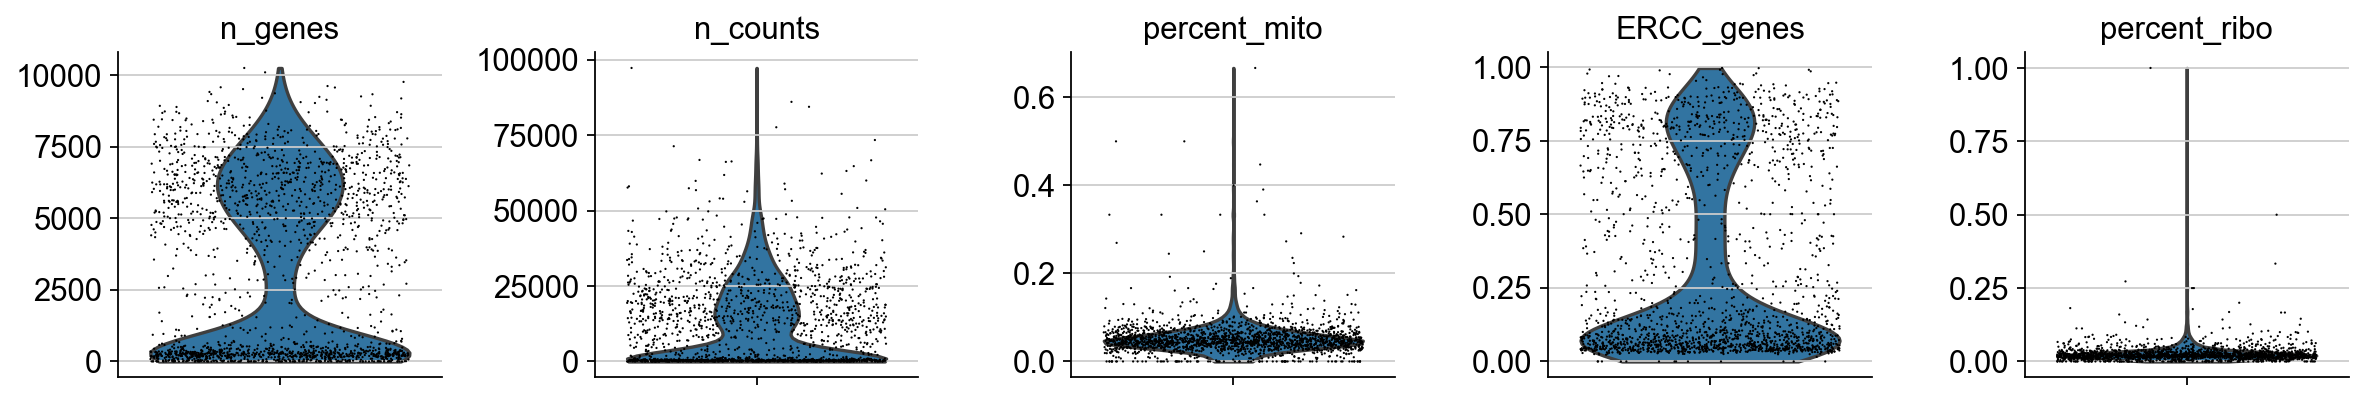

In [24]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito','ERCC_genes','percent_ribo'],
             jitter=0.4, multi_panel=True, save= "prefilter.pdf")

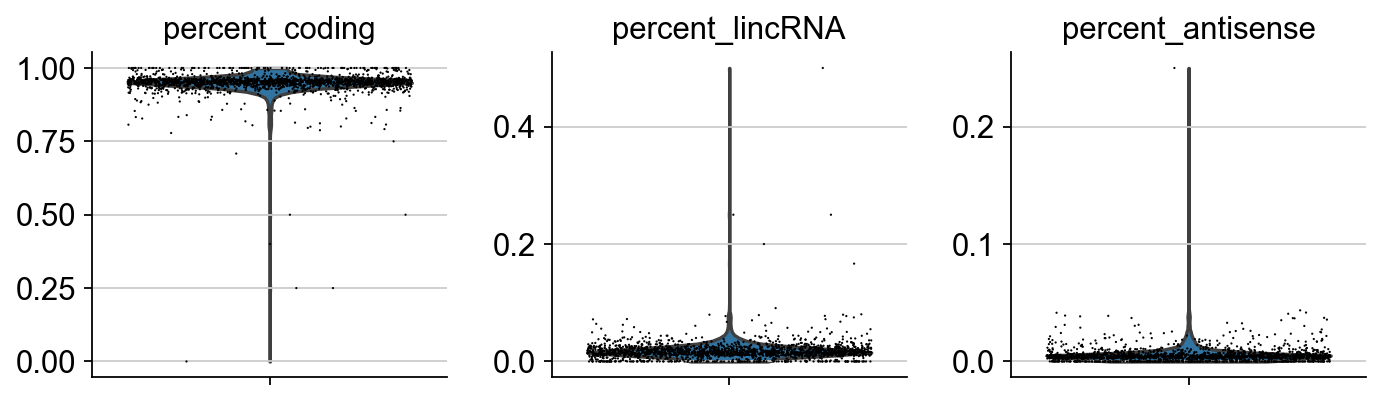

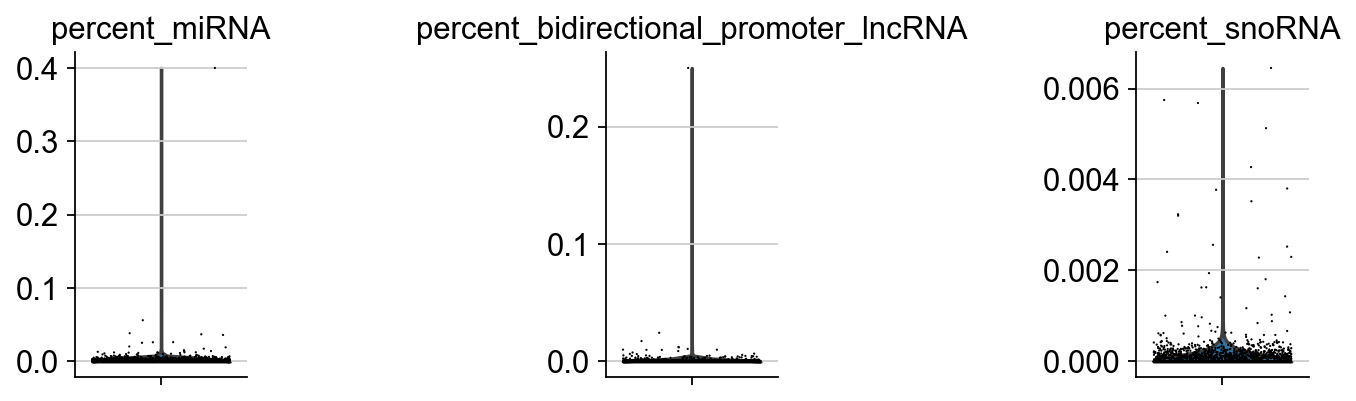

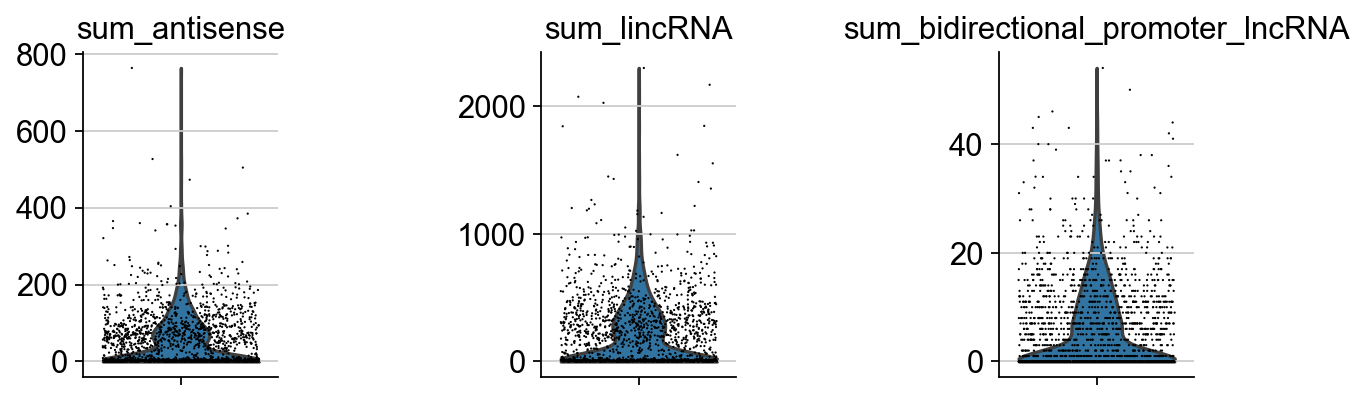

In [25]:
sc.pl.violin(adata, ['percent_coding', 'percent_lincRNA', 'percent_antisense'],
             jitter=0.4, multi_panel=True)
sc.pl.violin(adata, [ 'percent_miRNA', 'percent_bidirectional_promoter_lncRNA', 'percent_snoRNA'],
             jitter=0.4, multi_panel=True)
sc.pl.violin(adata, ['sum_antisense', 'sum_lincRNA', 'sum_bidirectional_promoter_lncRNA'],
             jitter=0.4, multi_panel=True)



In [28]:
#adata.write('./data/output/April2020_E18Hb-WT_quality.h5ad')

In [29]:
adata.obs.to_csv(
     './data/output/April2020_E18Hb-WT_meta.csv')

## Preprocessing 

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing counts per cell
    finished (0:00:01)


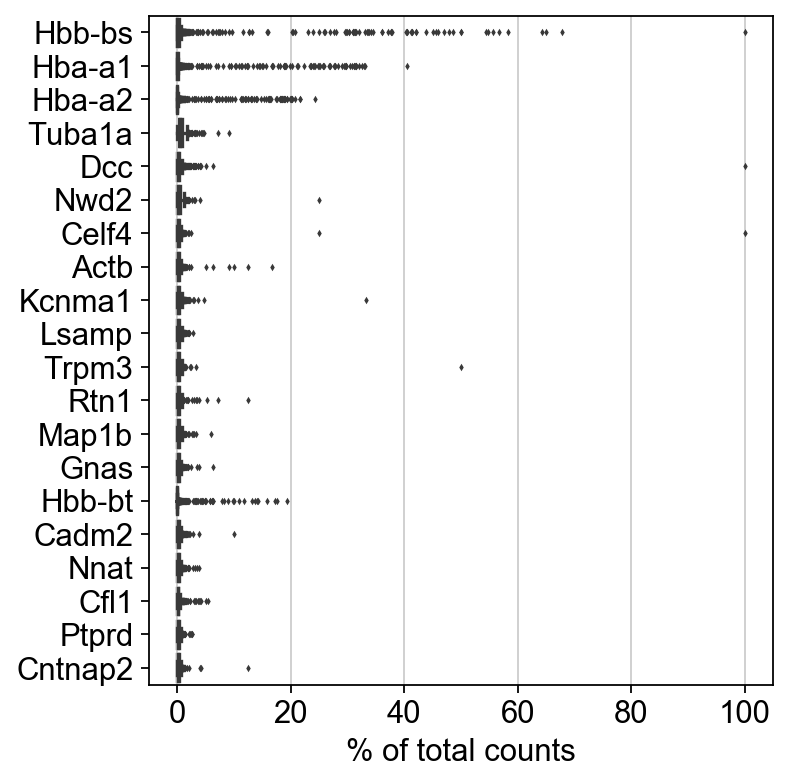

In [30]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering.

In [31]:
sc.pp.filter_cells(adata, min_genes=2000) #keep this high
sc.pp.filter_genes(adata, min_cells=3)

filtered out 907 cells that have less than 2000 genes expressed
filtered out 7830 genes that are detected in less than 3 cells


In [32]:
adata

AnnData object with n_obs × n_vars = 1002 × 28237 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'plate', 'stage', 'group', 'well_no'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells'
    layers: 'spliced', 'unspliced'

In [33]:
#some averages after the filtering...
print(np.median(adata.obs['ERCC_genes']), 'median % are ERCC_genes before filtering')
print(np.median(adata.obs['percent_mito']), "median mito_genes/total before filtering, without ERCC")
print(np.median(adata.obs['n_counts_withERCCmito']), "median number of reads with ERCC per cell")
print(np.median(adata.obs['n_counts_with_mito']), "median number of reads without ERCC per cell")
print(np.median(adata.obs['n_counts']), "median number of reads per cell, without ERCC and mito")
print(np.median(adata.obs['percent_ribo']), "median percent of ribosomal genes per cell")
print(np.median(adata.obs['n_genes']), "median number of genes per cell, without ERCC and mito")
print(np.median(adata.obs['percent_coding']), "median percent of protein_coding genes per cell")
print(np.median(adata.obs['percent_lincRNA']), "median percent of lincRNA genes per cell")
print(np.median(adata.obs['percent_antisense']), "median percent of antisense genes per cell")
print(np.median(adata.obs['percent_miRNA']), "median percent of miRNA genes per cell")
print(np.median(adata.obs['percent_bidirectional_promoter_lncRNA']), "median percent of bidirectional_promoter_lncRNA genes per cell")
print(np.median(adata.obs['percent_snoRNA']), "median percent of snoRNA genes per cell")
print(np.median(adata.obs['sum_miRNA']), "median or total miRNA genes per cell")
print(np.median(adata.obs['sum_antisense']), "median or total miRNA genes per cell")
print(np.median(adata.obs['sum_lincRNA']), "median or total miRNA genes per cell")


0.06393775 median % are ERCC_genes before filtering
0.042713225 median mito_genes/total before filtering, without ERCC
22269.898 median number of reads with ERCC per cell
20621.074 median number of reads without ERCC per cell
19922.945 median number of reads per cell, without ERCC and mito
0.02335795 median percent of ribosomal genes per cell
6066.5 median number of genes per cell, without ERCC and mito
0.95231014 median percent of protein_coding genes per cell
0.015856288 median percent of lincRNA genes per cell
0.0042006886 median percent of antisense genes per cell
0.0017944877 median percent of miRNA genes per cell
0.0004932083 median percent of bidirectional_promoter_lncRNA genes per cell
0.000117882984 median percent of snoRNA genes per cell
33.05338 median or total miRNA genes per cell
82.01845 median or total miRNA genes per cell
323.20007 median or total miRNA genes per cell


Note you can also use the function `pp.calculate_qc_metrics` to compute the fraction of mitochondrial genes and additional measures.

In [34]:
sc.pp.calculate_qc_metrics(adata, expr_type='counts', var_type='genes', qc_vars=(), percent_top=(50, 100, 200, 500), inplace=True)

In [35]:
# Run this to visualise the QC results
sc.pp.calculate_qc_metrics(adata, expr_type='counts', var_type='genes', qc_vars=(), percent_top=(50, 100, 200, 500), inplace=False)


(                            n_genes_by_counts  log1p_n_genes_by_counts  \
 Habenula_001___L1__left_9                7928                 8.978282   
 Habenula_001___L1__left_10               6912                 8.841159   
 Habenula_001___L1__left_12               7658                 8.943637   
 Habenula_001___L1__left_14               5594                 8.629629   
 Habenula_001___L1__left_15               6657                 8.803574   
 ...                                       ...                      ...   
 Habenula_005___LR__mix_377               2887                 7.968320   
 Habenula_005___LR__mix_378               7928                 8.978282   
 Habenula_005___LR__mix_379               7841                 8.967249   
 Habenula_005___LR__mix_380               5513                 8.615046   
 Habenula_005___LR__mix_381               5611                 8.632662   
 
                             total_counts  log1p_total_counts  \
 Habenula_001___L1__left_9   3905

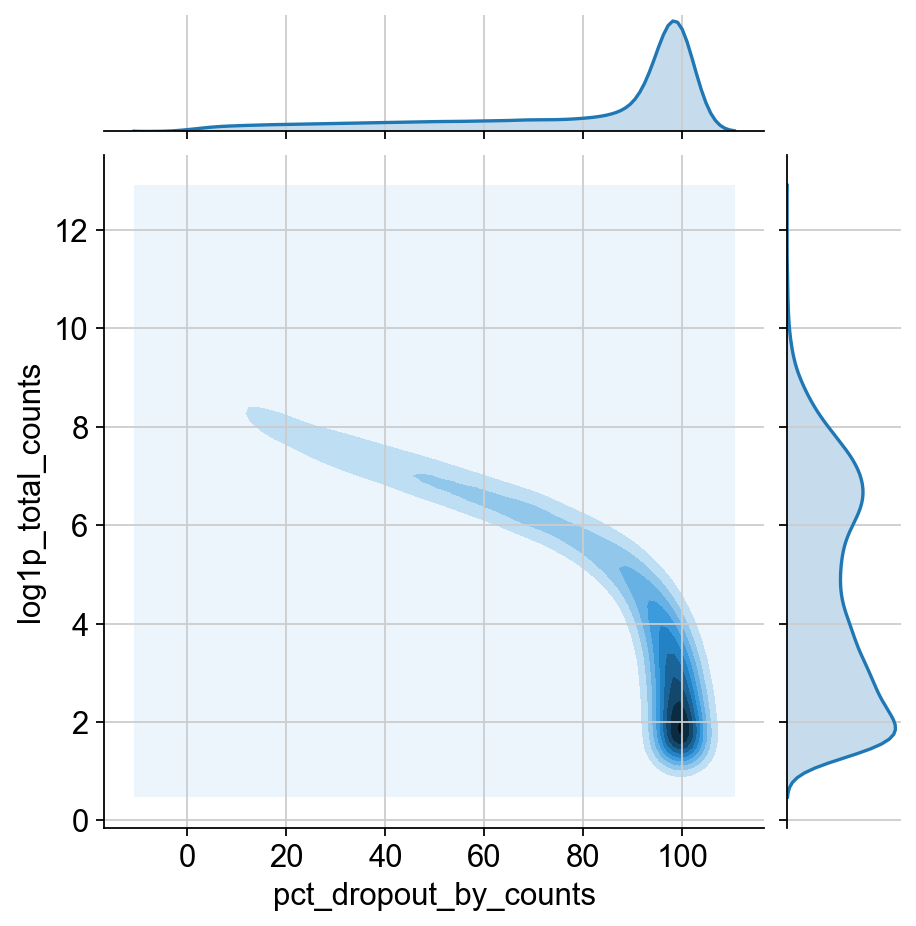

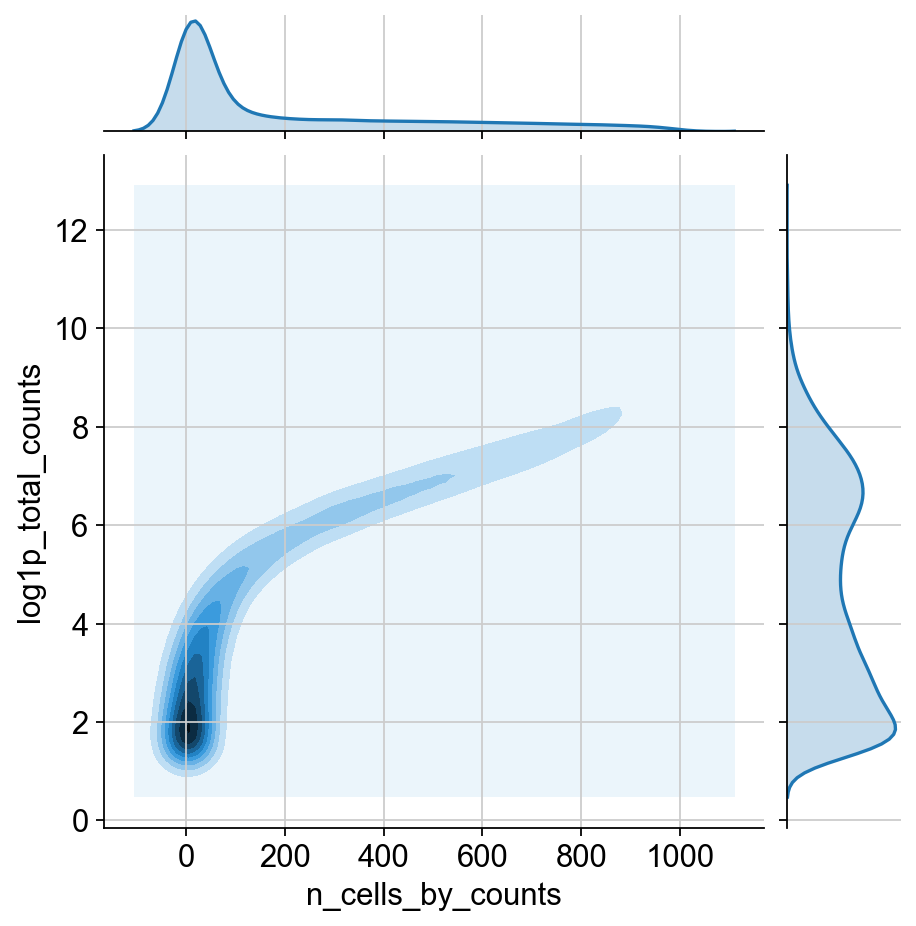

In [36]:
import seaborn as sns
sns.jointplot("pct_dropout_by_counts", "log1p_total_counts", data=adata.var, kind="kde")
sns.jointplot("n_cells_by_counts", "log1p_total_counts", data=adata.var, kind="kde")


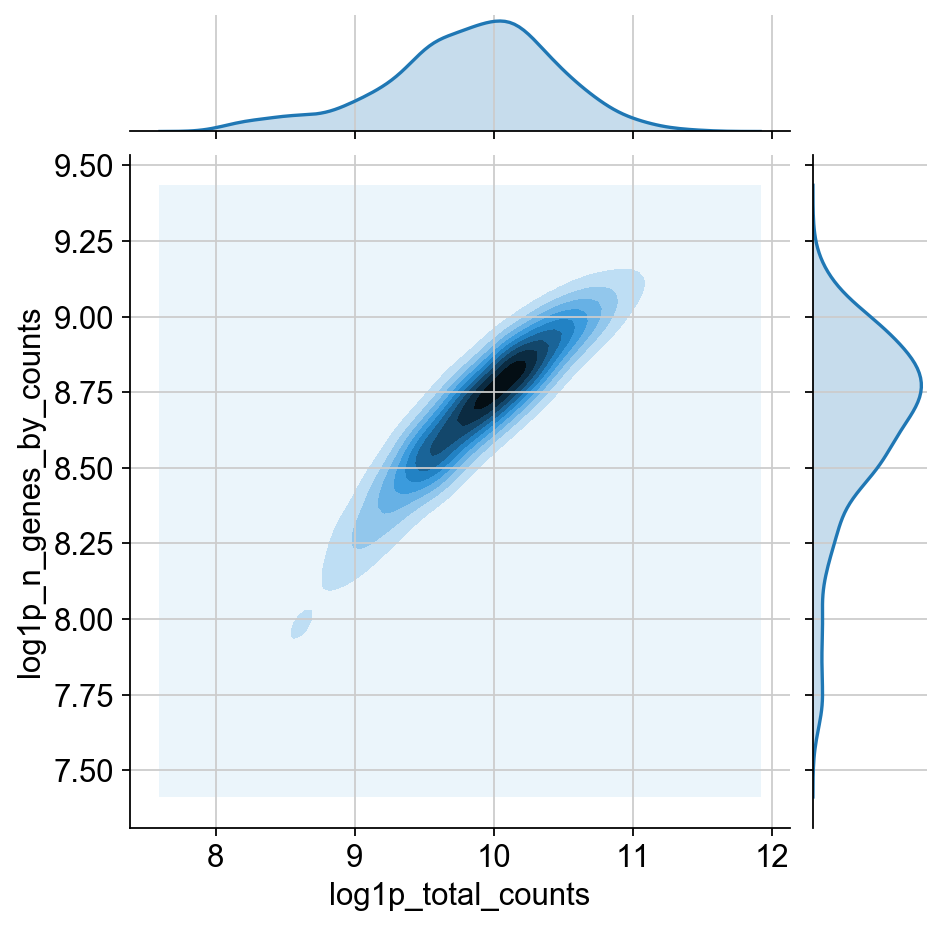

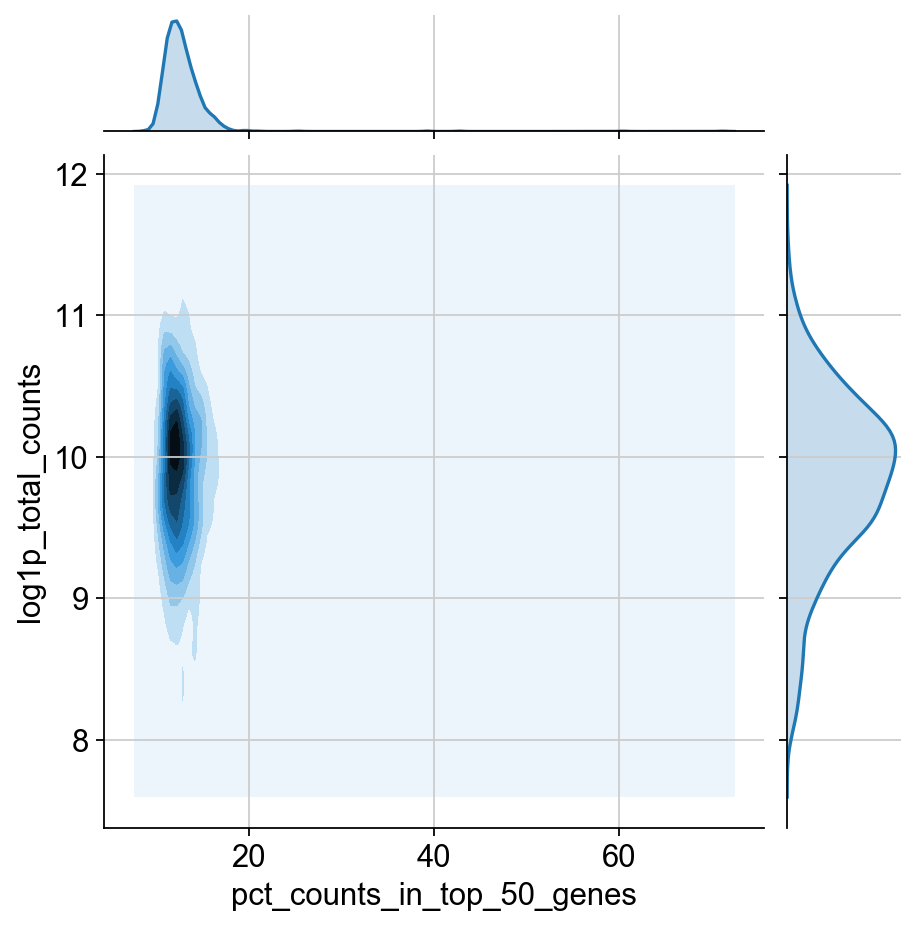

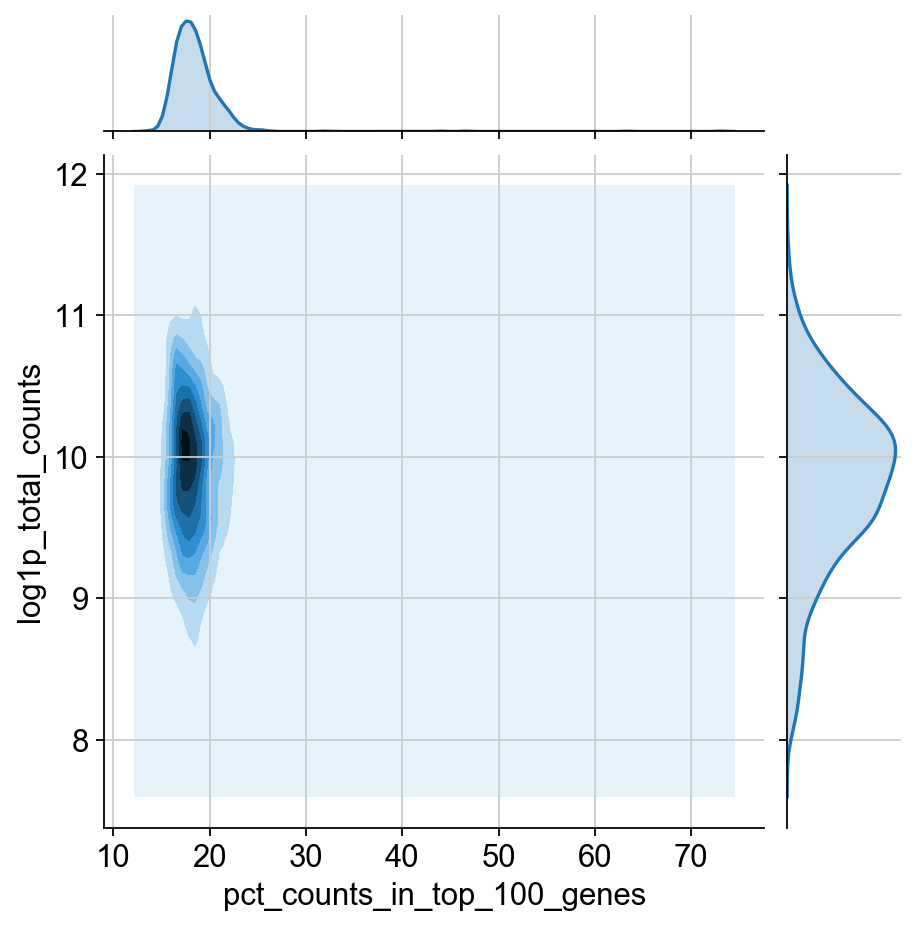

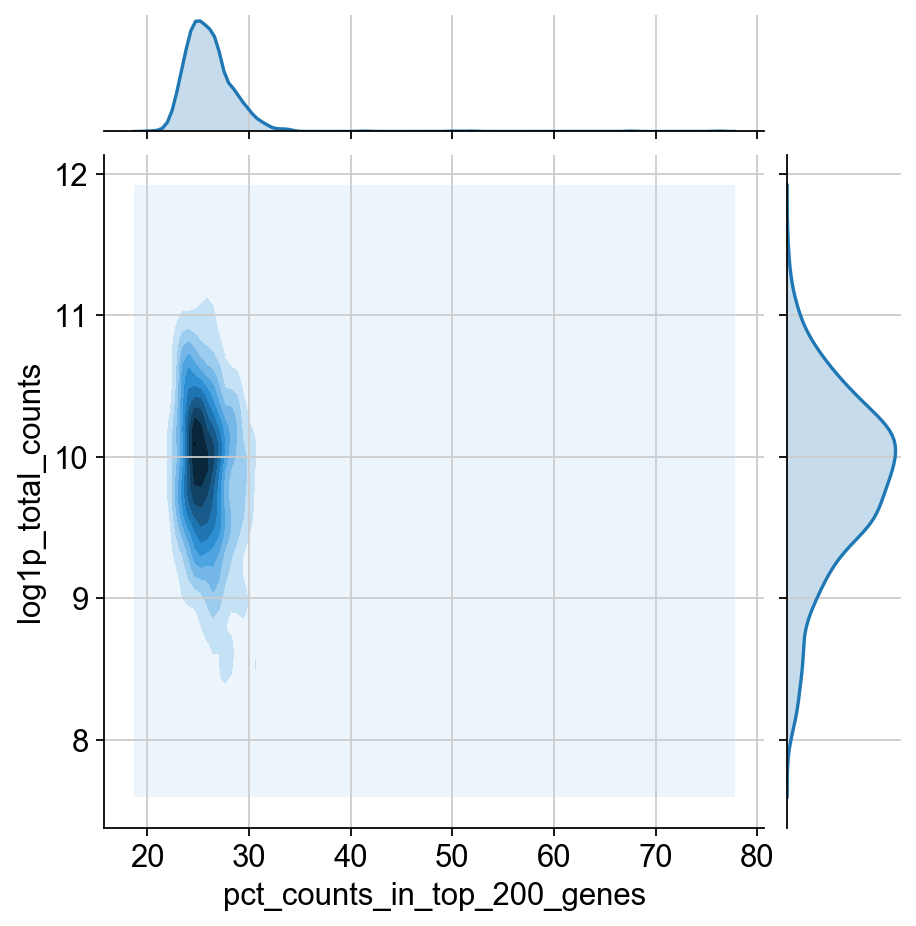

In [37]:
sns.jointplot("log1p_total_counts", "log1p_n_genes_by_counts", data=adata.obs, kind="kde") #hex
sns.jointplot("pct_counts_in_top_50_genes", "log1p_total_counts", data=adata.obs, kind="kde")
sns.jointplot("pct_counts_in_top_100_genes", "log1p_total_counts", data=adata.obs, kind="kde")
sns.jointplot("pct_counts_in_top_200_genes", "log1p_total_counts", data=adata.obs, kind="kde")


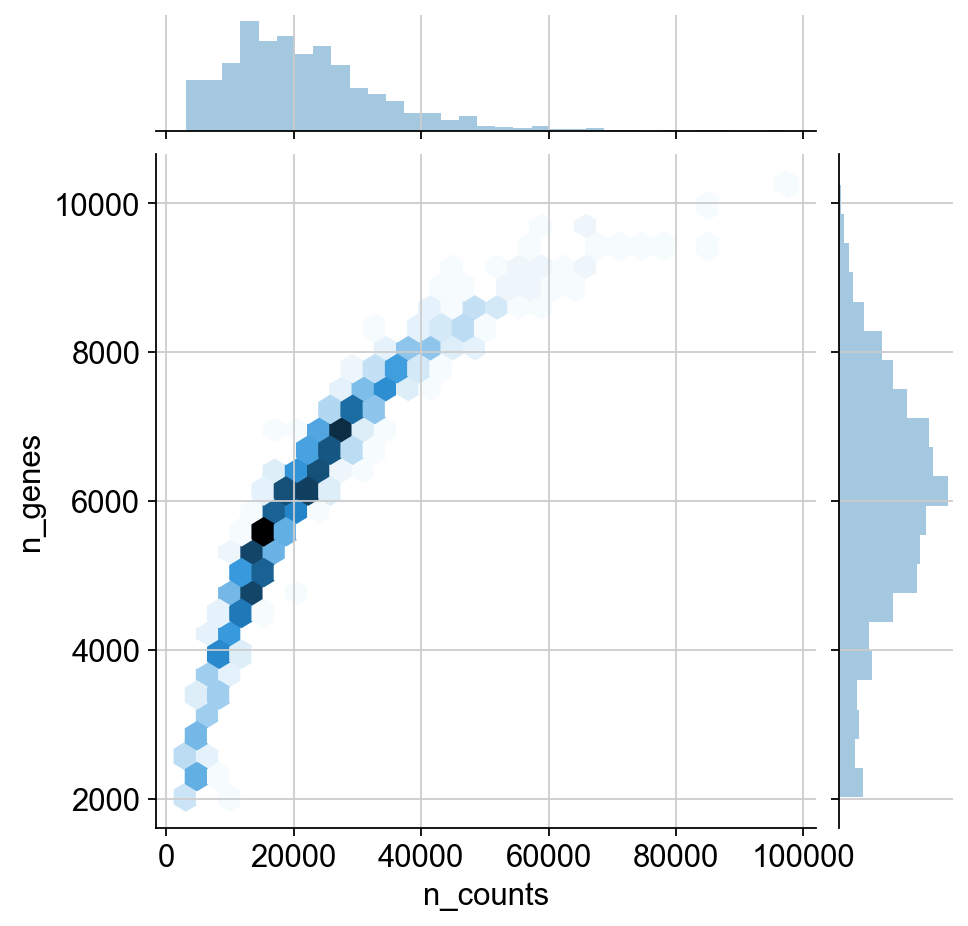

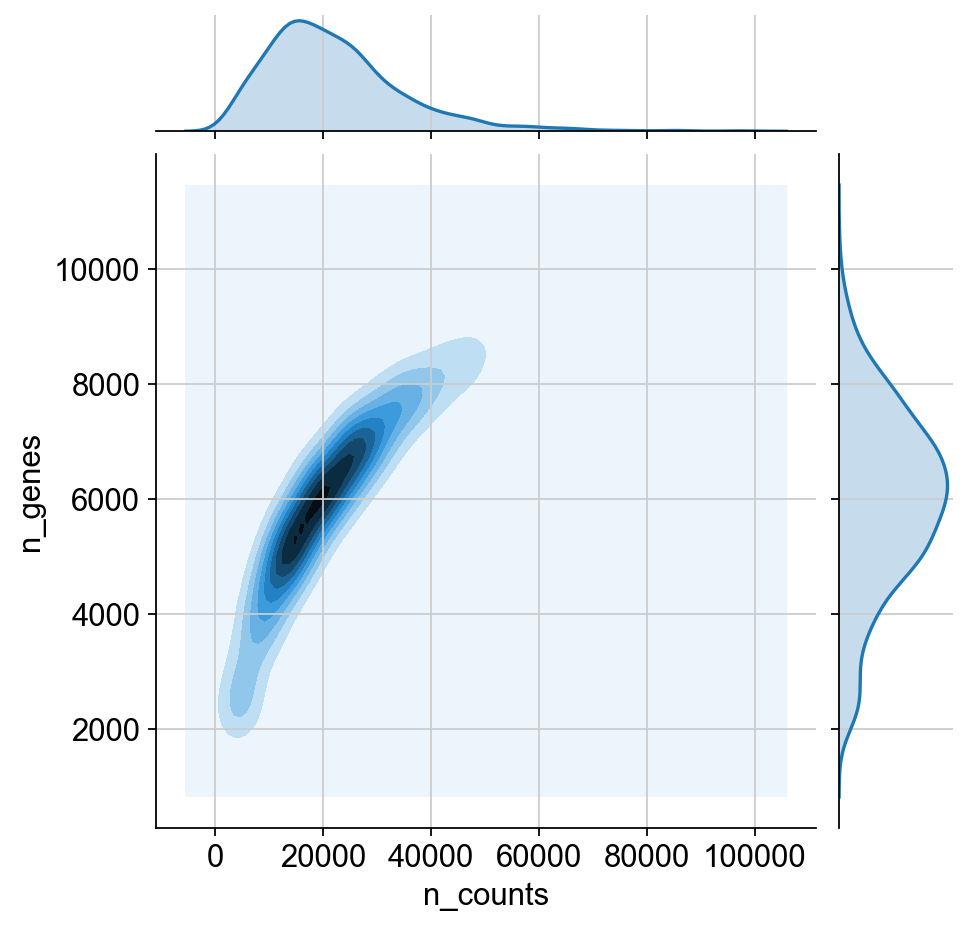

In [38]:
sns.jointplot("n_counts", "n_genes", data=adata.obs, kind="hex")
sns.jointplot("n_counts", "n_genes", data=adata.obs, kind="kde")
#kind : { "scatter" | "reg" | "resid" | "kde" | "hex" }

Remove cells that have too many mitochondrial genes expressed or too many total counts.

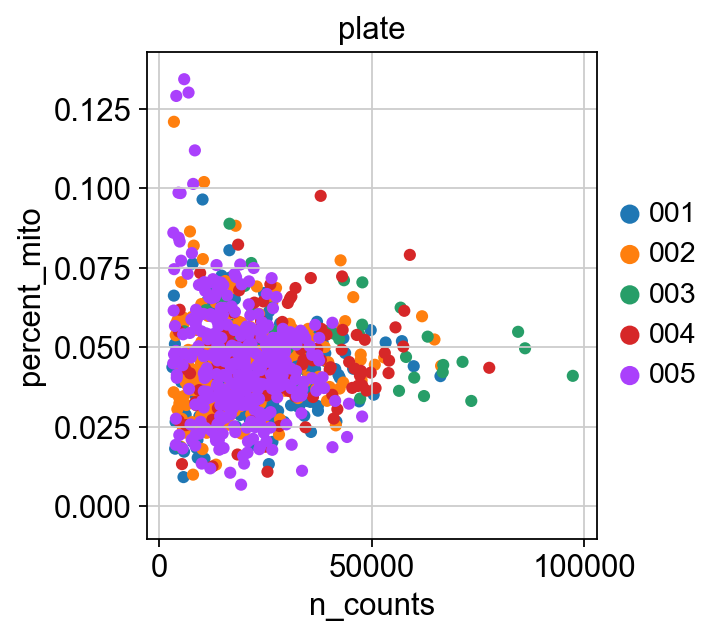

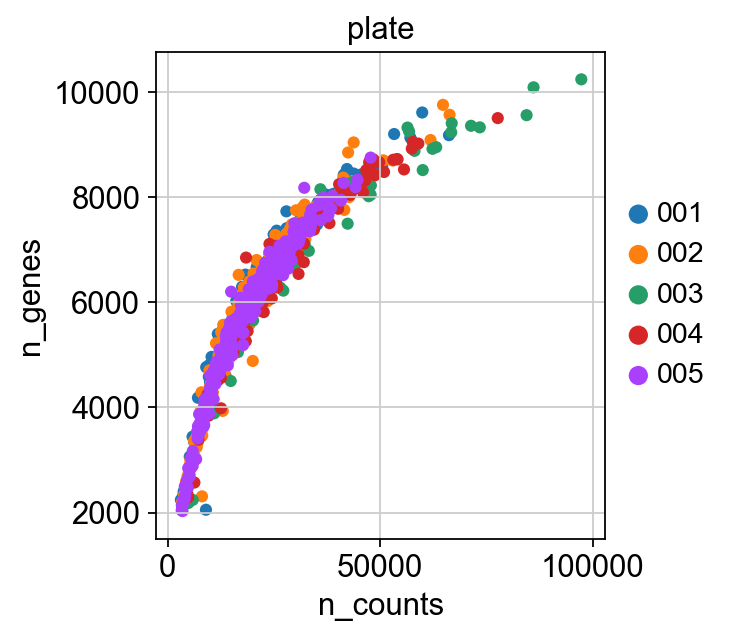

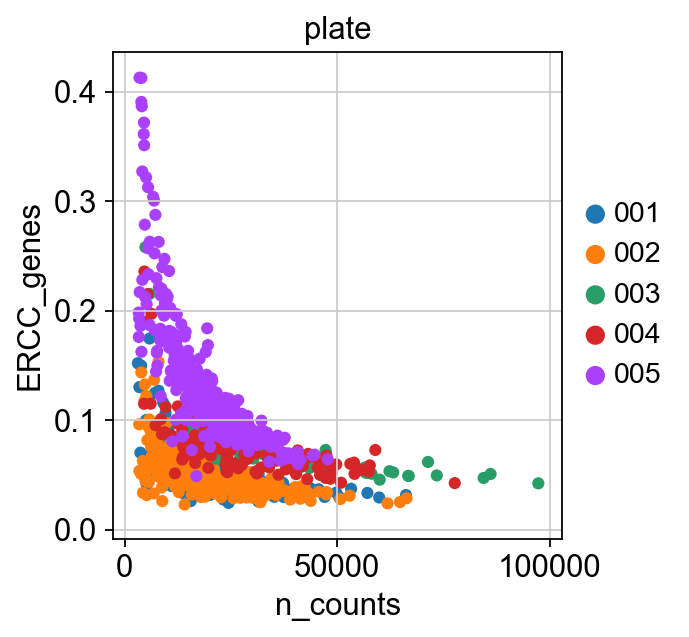

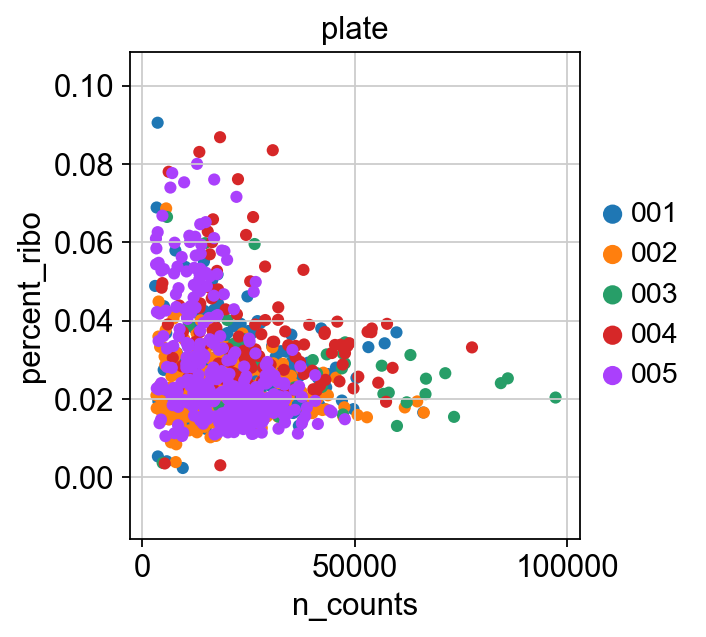

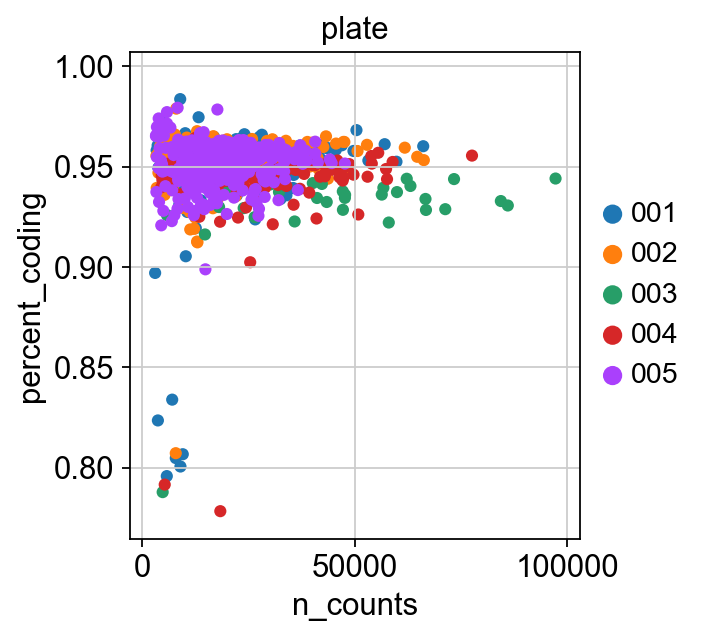

In [39]:
#look at the distribution of categories colored by mito %
sc.pl.scatter(adata, x='n_counts', y='percent_mito',color = 'plate', save= "scatter_plot_prefilter_1.png")
sc.pl.scatter(adata, x='n_counts', y='n_genes',color = 'plate', save= "scatter_plot_prefilter_2.png")
sc.pl.scatter(adata, x='n_counts', y='ERCC_genes',color = 'plate', save= "scatter_plot_prefilter_3.png")
sc.pl.scatter(adata, x='n_counts', y='percent_ribo',color = 'plate', save= "scatter_plot_prefilter_4.png")
sc.pl.scatter(adata, x='n_counts', y='percent_coding',color = 'plate', save= "scatter_plot_prefilter_5.png")


Actually do the filtering.

In [40]:
adata

AnnData object with n_obs × n_vars = 1002 × 28237 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'plate', 'stage', 'group', 'well_no', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

In [41]:
adata = adata[adata.obs['n_counts'] < 50000, :] 
adata = adata[adata.obs['percent_mito'] < 0.15, :]
adata = adata[adata.obs['percent_ribo'] < 0.2, :]
adata = adata[adata.obs['ERCC_genes'] < 0.3, :]
adata = adata[adata.obs['percent_coding'] > 0.85, :]

In [42]:
adata

View of AnnData object with n_obs × n_vars = 948 × 28237 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'plate', 'stage', 'group', 'well_no', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

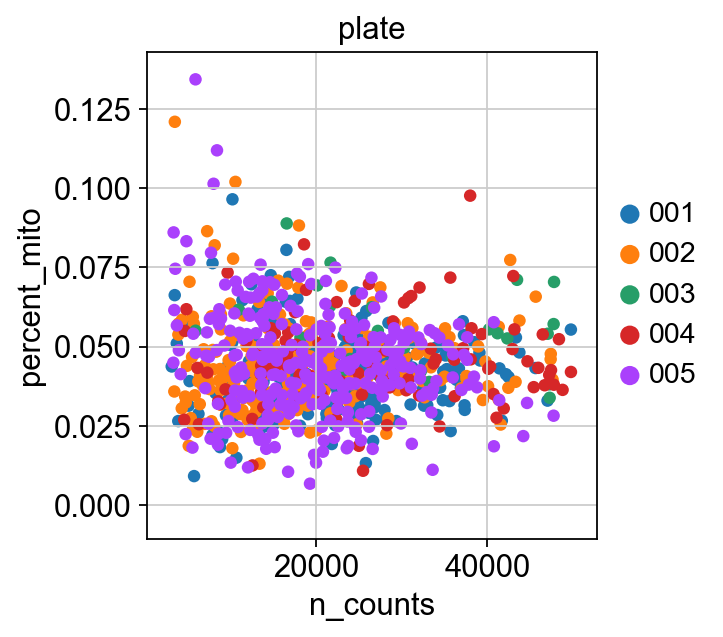

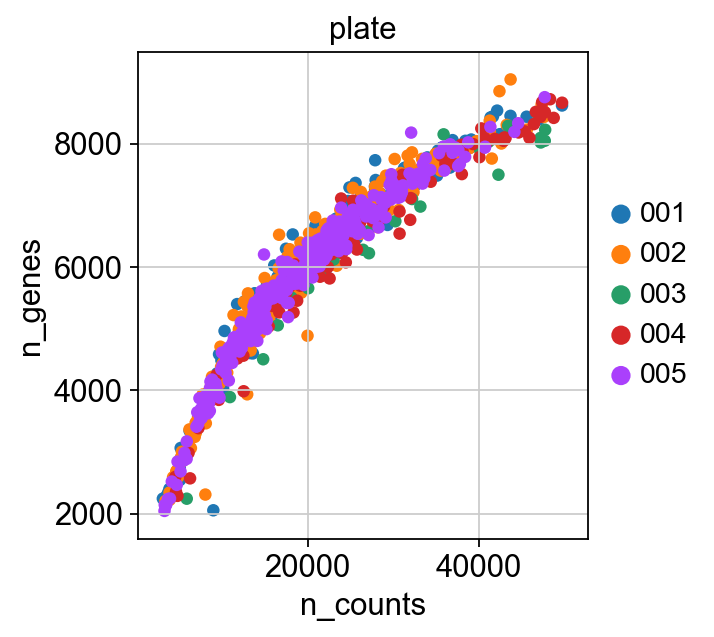

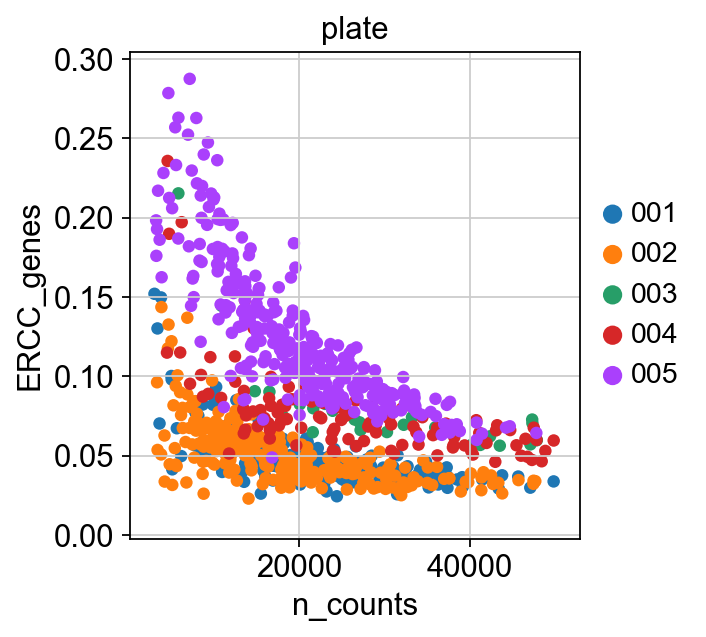

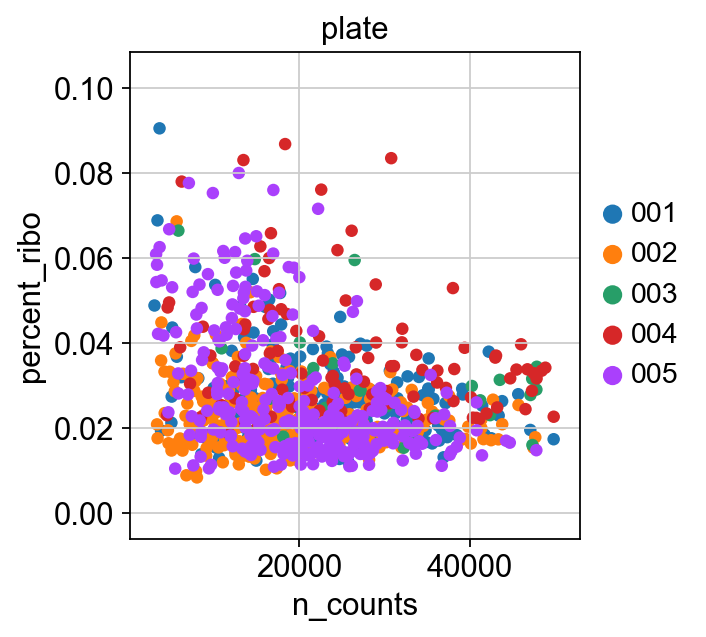

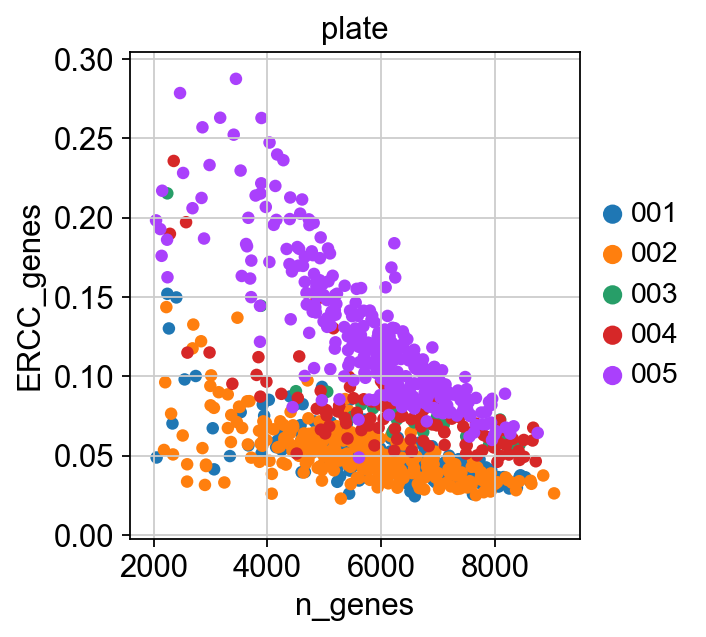

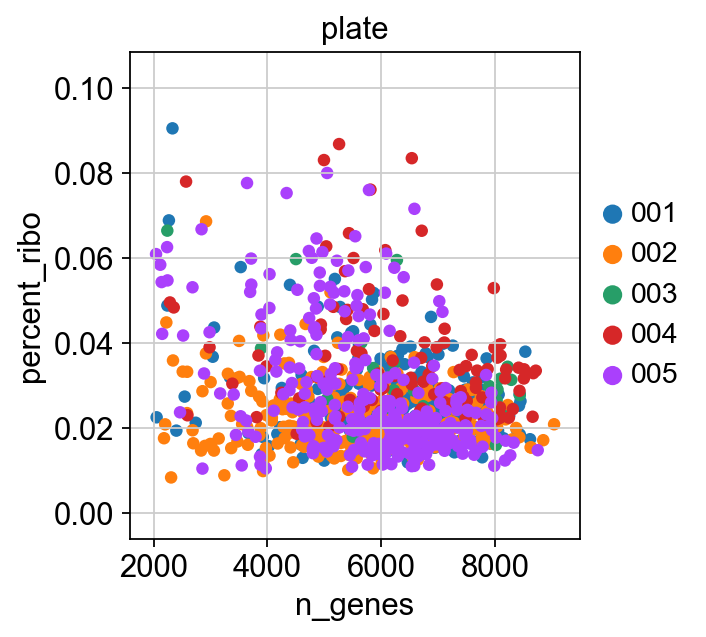

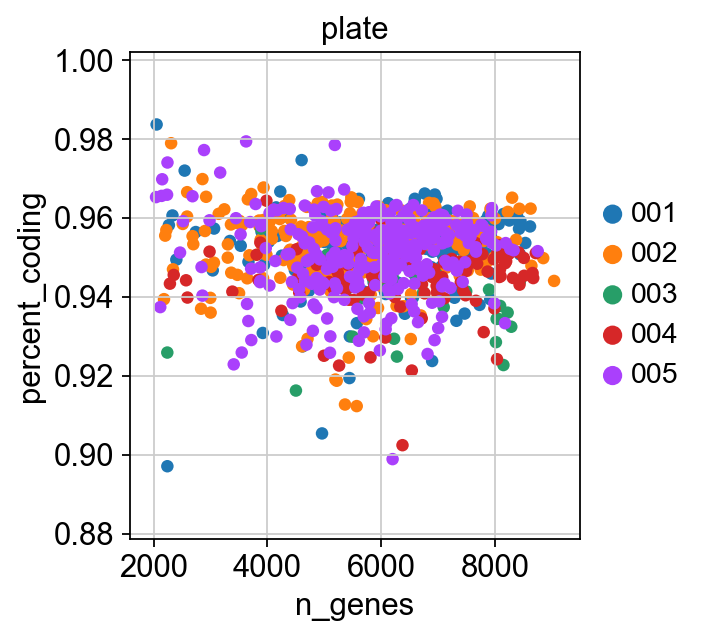

In [43]:
#look at the distribution of categories colored by mito %
sc.pl.scatter(adata, x='n_counts', y='percent_mito',color = 'plate', save= "scatter_plot_filter_1.png")
sc.pl.scatter(adata, x='n_counts', y='n_genes',color = 'plate', save= "scatter_plot_filter_2.png")
sc.pl.scatter(adata, x='n_counts', y='ERCC_genes',color = 'plate', save= "scatter_plot_filter_3.png")
sc.pl.scatter(adata, x='n_counts', y='percent_ribo',color = 'plate', save= "scatter_plotefilter_4.png")
sc.pl.scatter(adata, x='n_genes', y='ERCC_genes',color = 'plate', save= "scatter_plot_filter_5.png")
sc.pl.scatter(adata, x='n_genes', y='percent_ribo',color = 'plate', save= "scatter_plot_filter_6.png")
sc.pl.scatter(adata, x='n_genes', y='percent_coding',color = 'plate', save= "scatter_plot_filter_7.png")


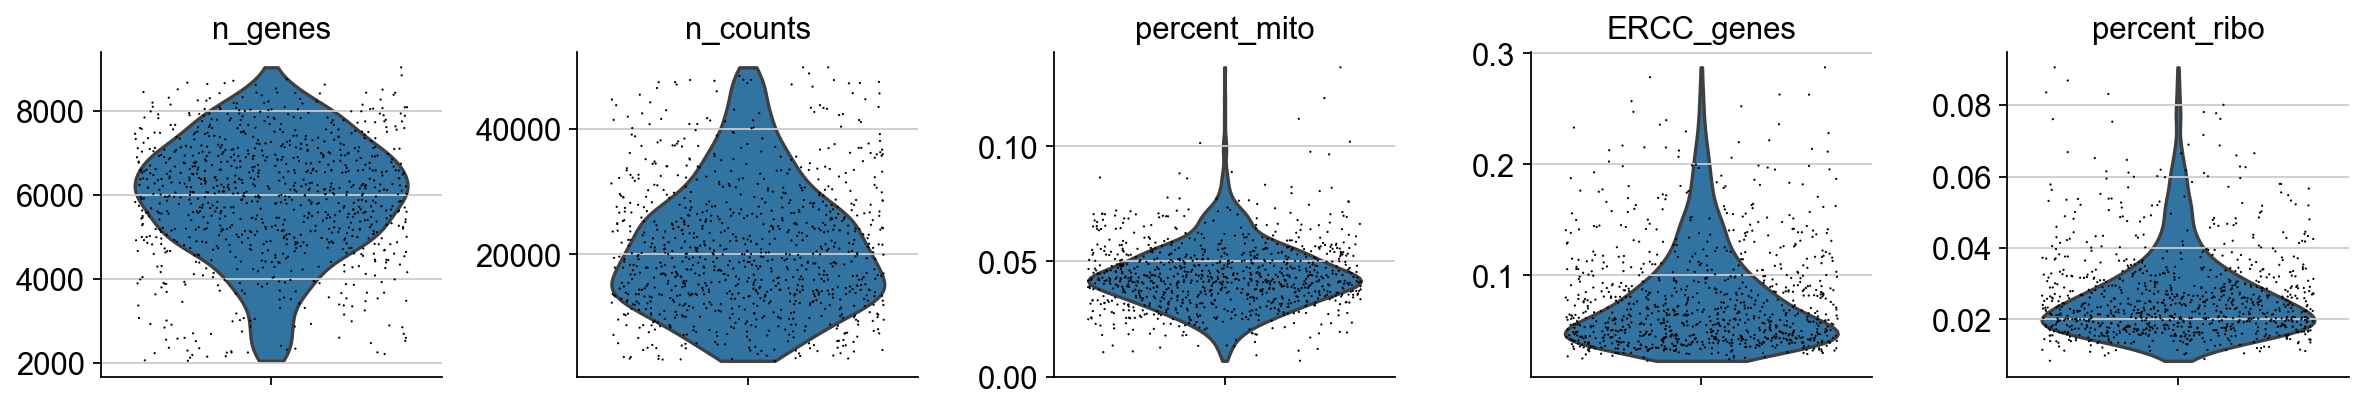

In [44]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito','ERCC_genes','percent_ribo'],
             jitter=0.4, multi_panel=True, save= "filtered.pdf")

In [45]:
#adata.write('./data/output/April2020_E18Hb-WT_quality_filtered.h5ad')

In [48]:
adata = sc.read_h5ad('../write/Lieke_Habenula_2019Oct_E18-wt_5plates_readytouse_2000g_e3_filtered.h5ad')

In [49]:
adata

AnnData object with n_obs × n_vars = 948 × 28237 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'plate', 'stage', 'group', 'well_no', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

In [11]:
adata = sc.read('./data/output/April2020_E18Hb-WT_quality_filtered.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 948 × 28237
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'plate', 'stage', 'group', 'well_no', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

# Normalisation 
Standard:
Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

Normalise to a fraction:
Use "fraction=0.9" to take only a certain fraction of genes into account for normalisation, not considering the very highly expressed genes

In [12]:
sc.pp.normalize_total(adata, key_added='n_counts_norm',layers = 'all')

normalizing counts per cell
    finished (0:00:01)


Logarithmize the data.

In [13]:
sc.pp.log1p(adata)

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object. While many people consider the normalized data matrix as the "relevant data" for visualization and differential testing, some would prefer to store the unnormalized data.

In [14]:
adata.raw = adata
adata_raw = adata

Identify highly-variable genes.

In [53]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


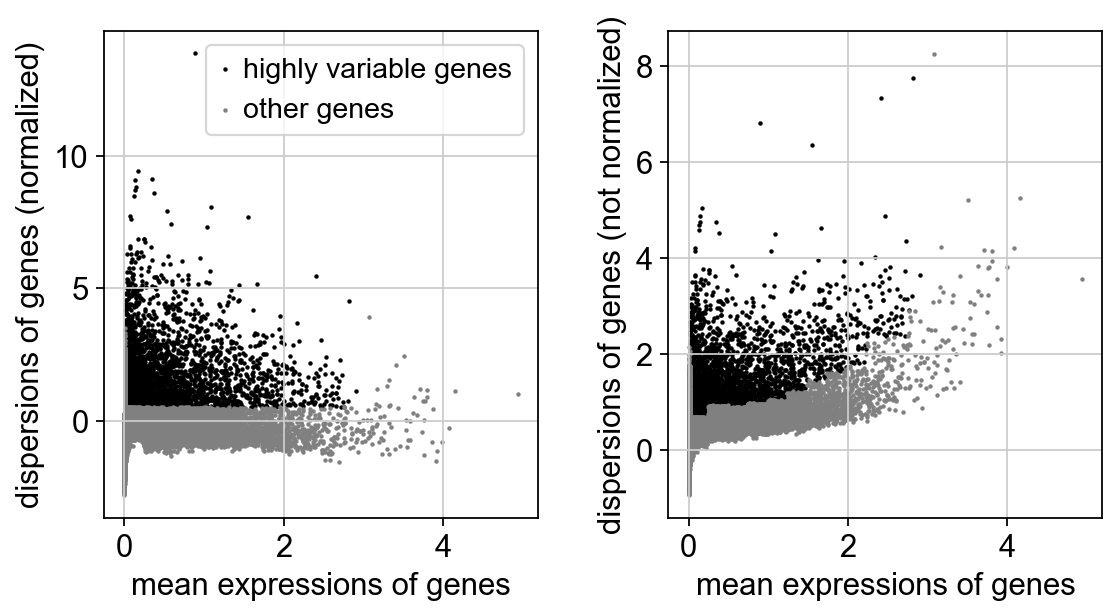

In [54]:
sc.pl.highly_variable_genes(adata)

Actually do the filtering.

In [55]:
adata = adata[:, adata.var['highly_variable']]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [56]:
sc.pp.regress_out(adata, ['n_counts','percent_mito'])

regressing out ['n_counts', 'percent_mito']
    finished (0:00:26)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [57]:
sc.pp.scale(adata, max_value=10)

In [58]:
adata.write('./data/output/April2020_E18Hb-WT_quality_filtered_normalized.h5ad')

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [64]:
adata = sc.read('./data/output/April2020_E18Hb-WT_quality_filtered_normalized.h5ad')
adata

AnnData object with n_obs × n_vars = 948 × 5006 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'plate', 'stage', 'group', 'well_no', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts_norm'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

In [65]:
sc.tl.pca(adata, svd_solver='arpack')

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:01)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

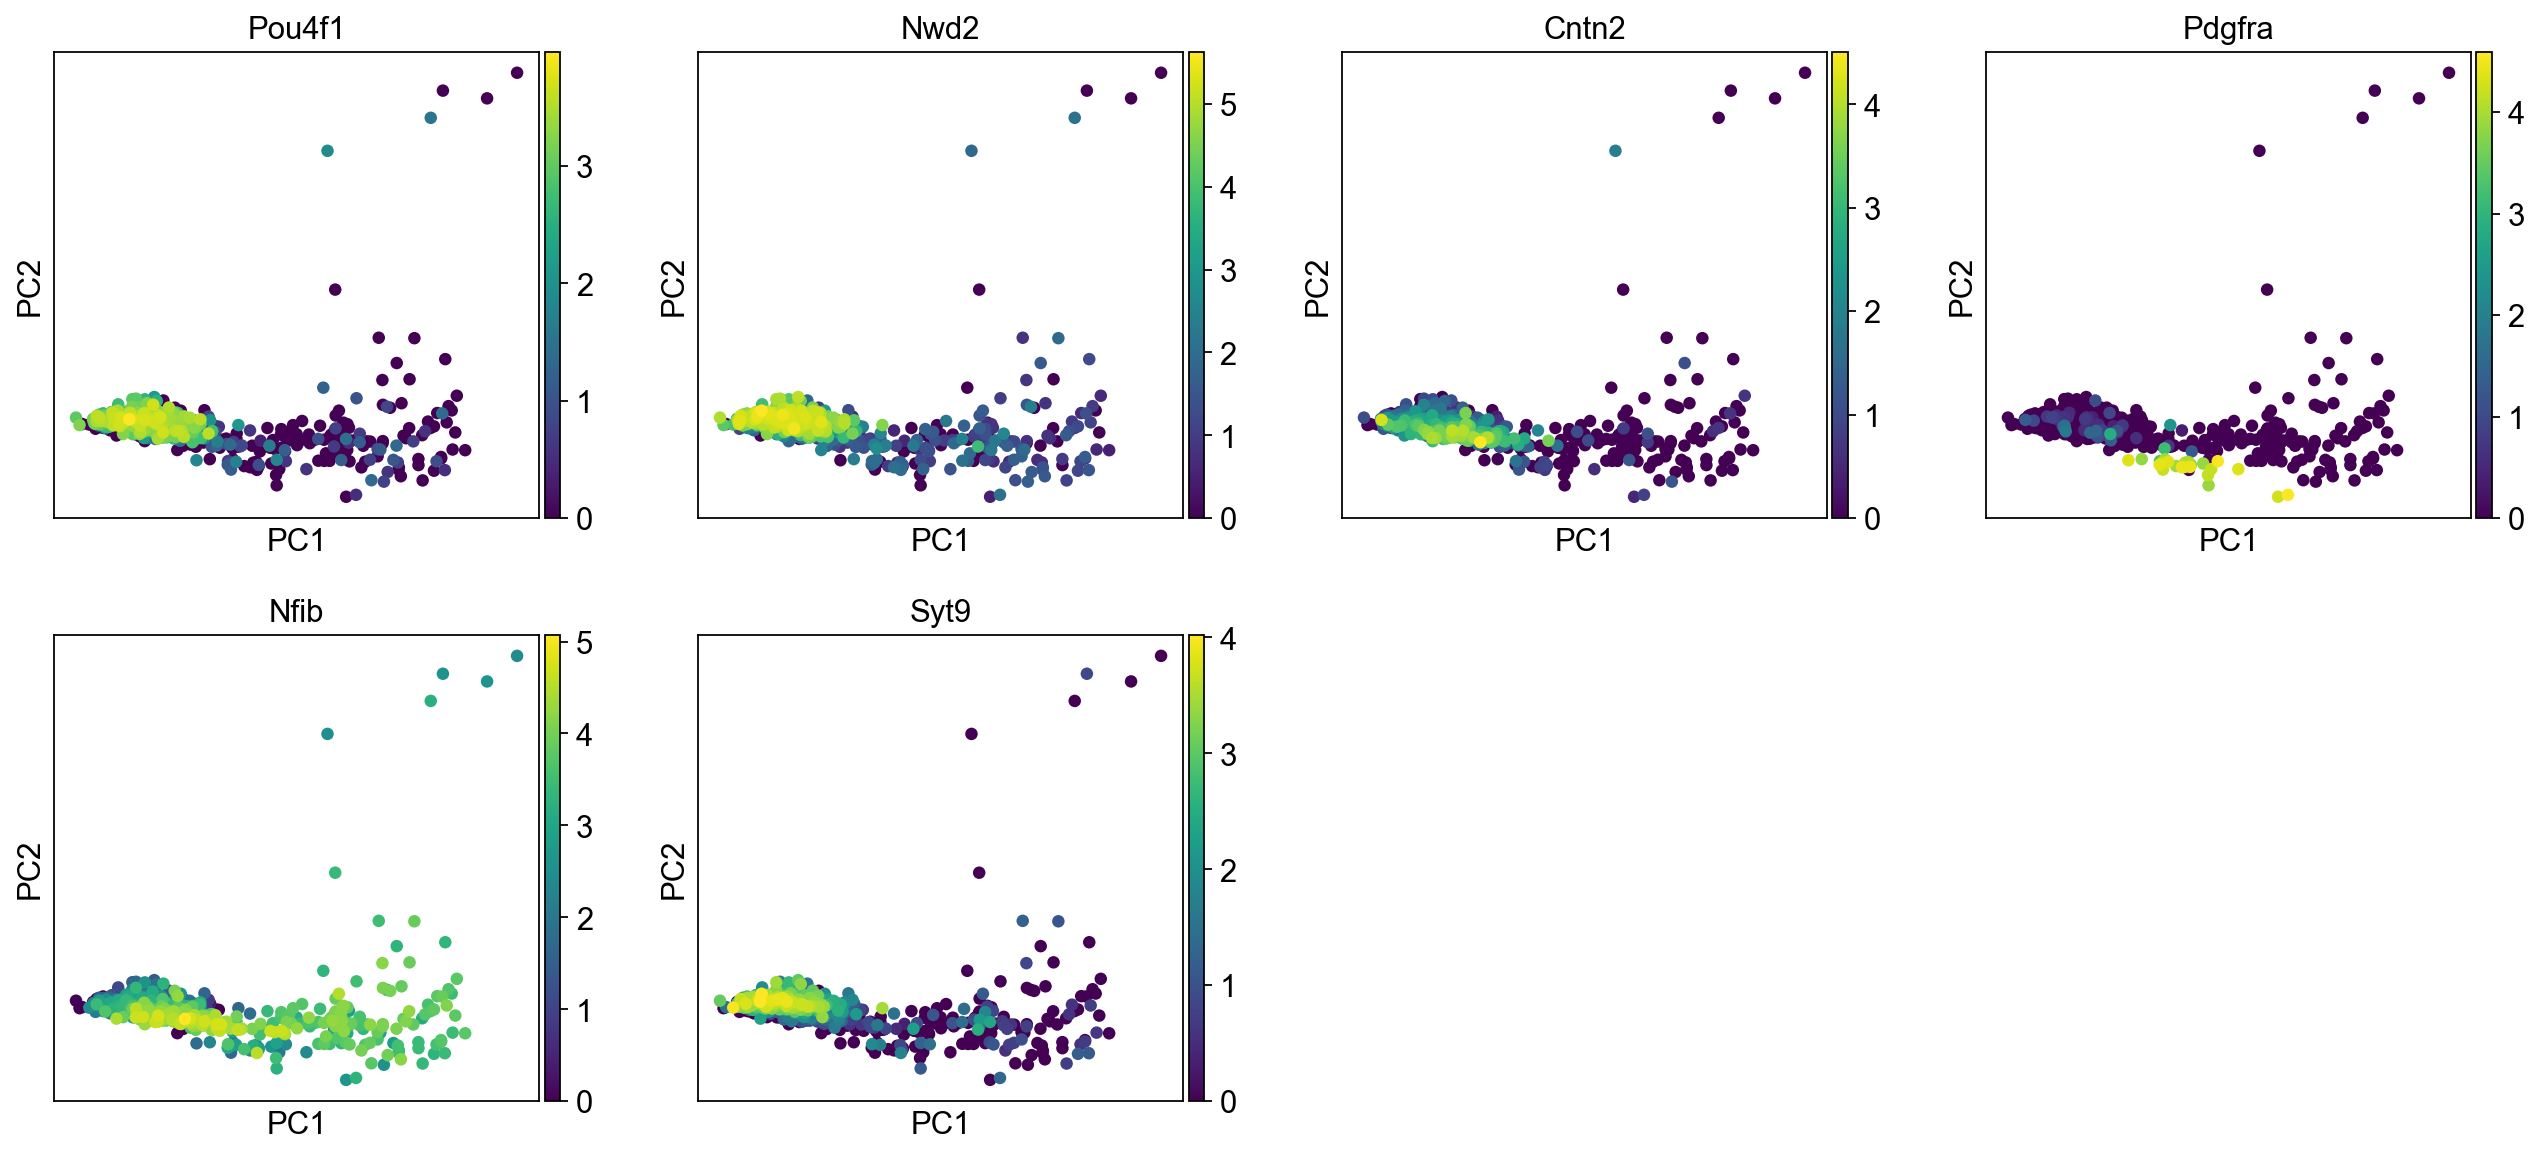

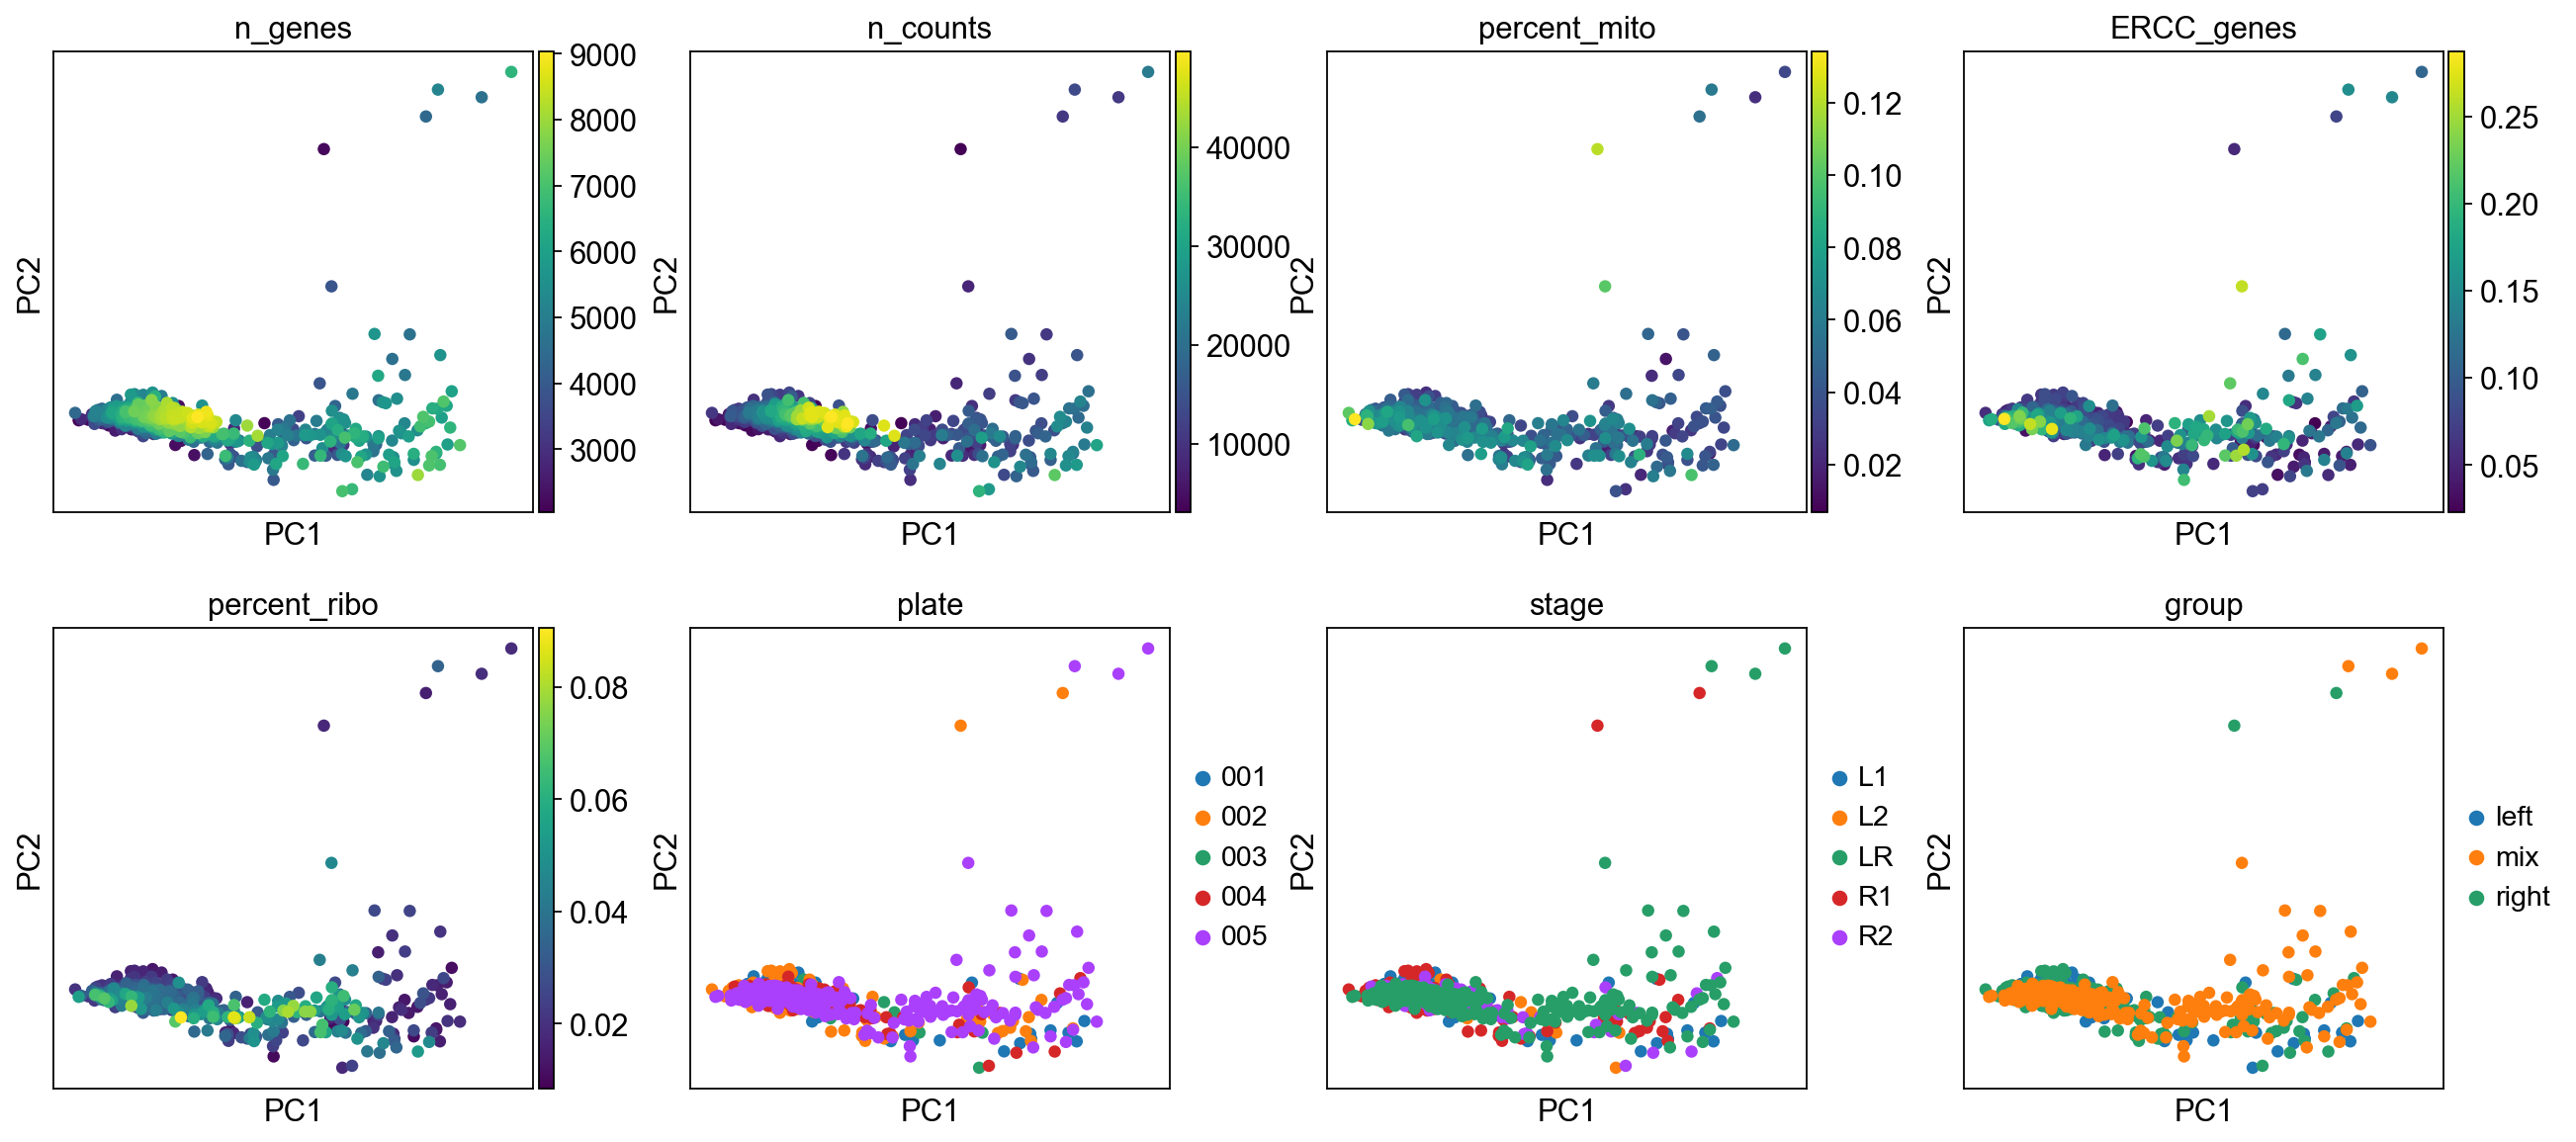

In [66]:
sc.pl.pca(adata, color=['Pou4f1', "Nwd2", 'Cntn2', 'Pdgfra', 'Nfib', 'Syt9'], save = "2.pdf")
sc.pl.pca(adata, color=['n_genes', 'n_counts', 'percent_mito','ERCC_genes','percent_ribo','plate', 'stage', 'group'], save = "1.pdf")

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

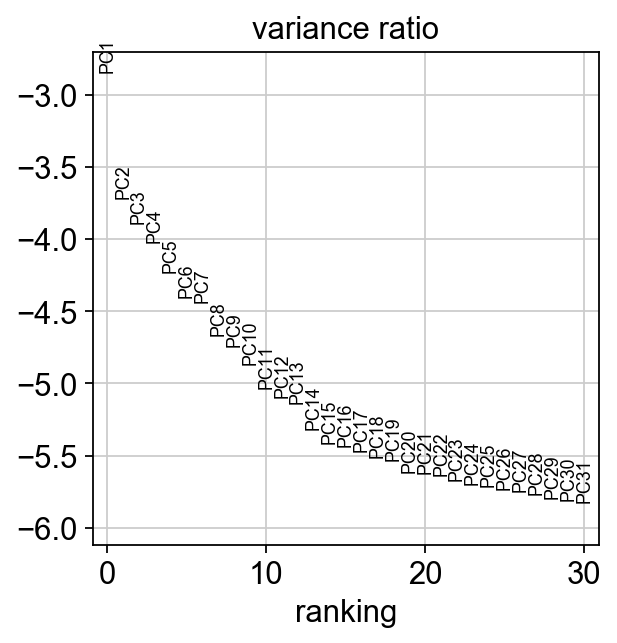

In [67]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

## Computing the neighborhood graph

In [69]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)


## Embedding the neighborhood graph

In [61]:
sc.tl.umap(adata)

computing UMAP
    using 'X_pca' with n_pcs = 40
    finished (0:00:04.82) --> added
    'X_umap', UMAP coordinates (adata.obsm)


saving figure to file ./figures/umap_umap_plate_stage.pdf


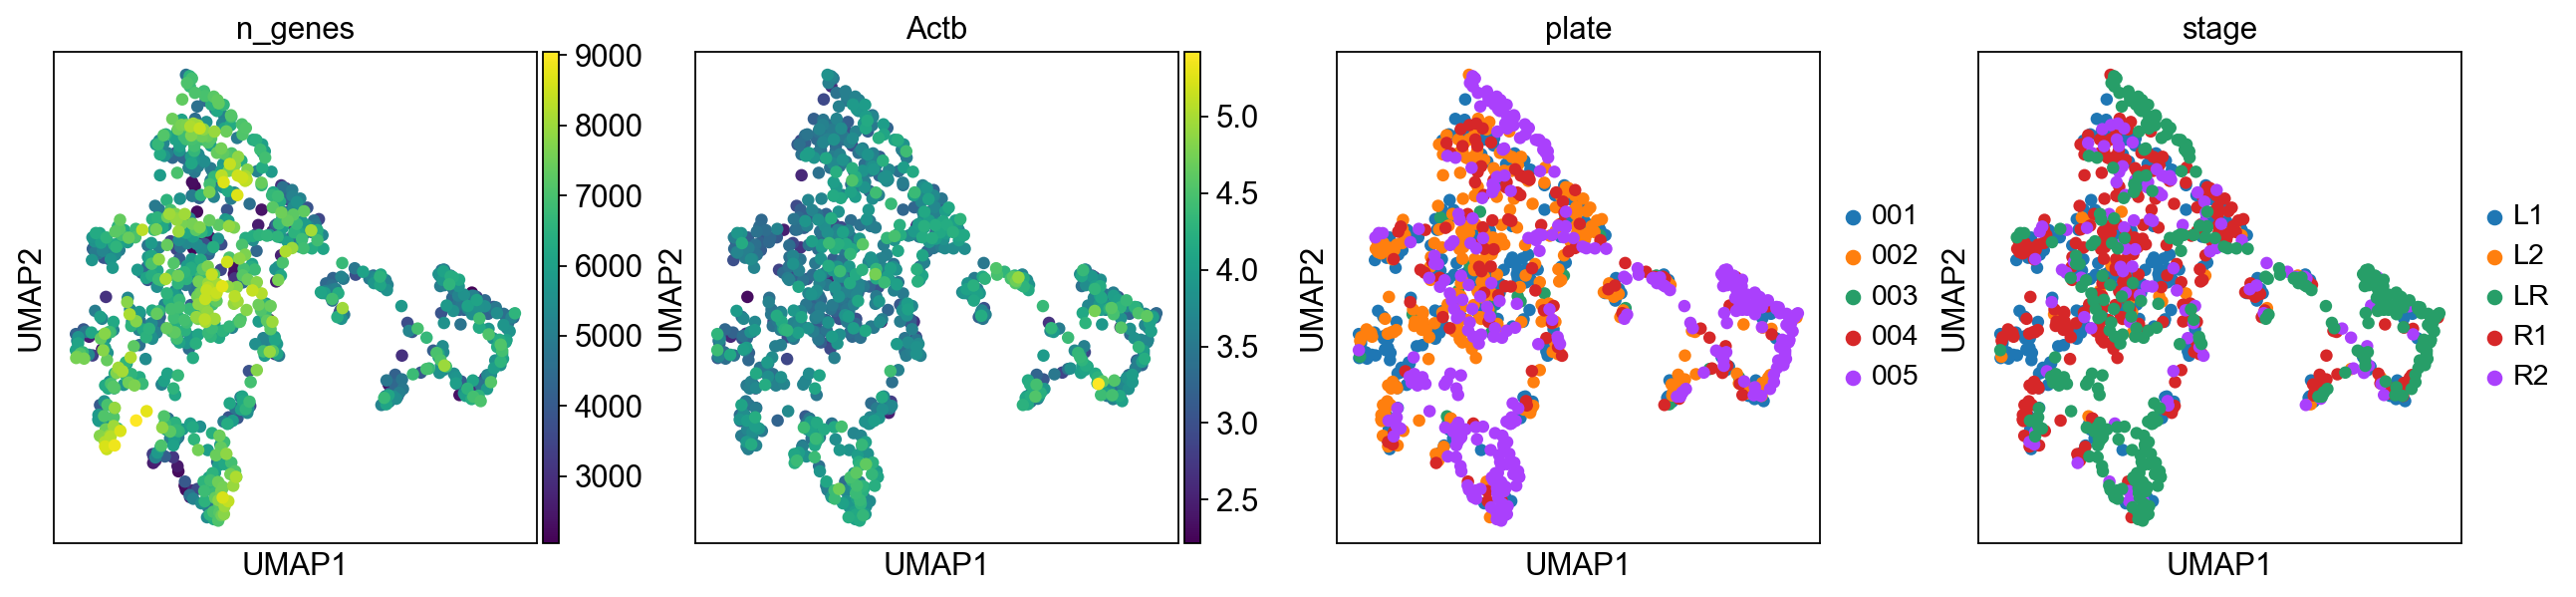

saving figure to file ./figures/umap__umap_markers.pdf


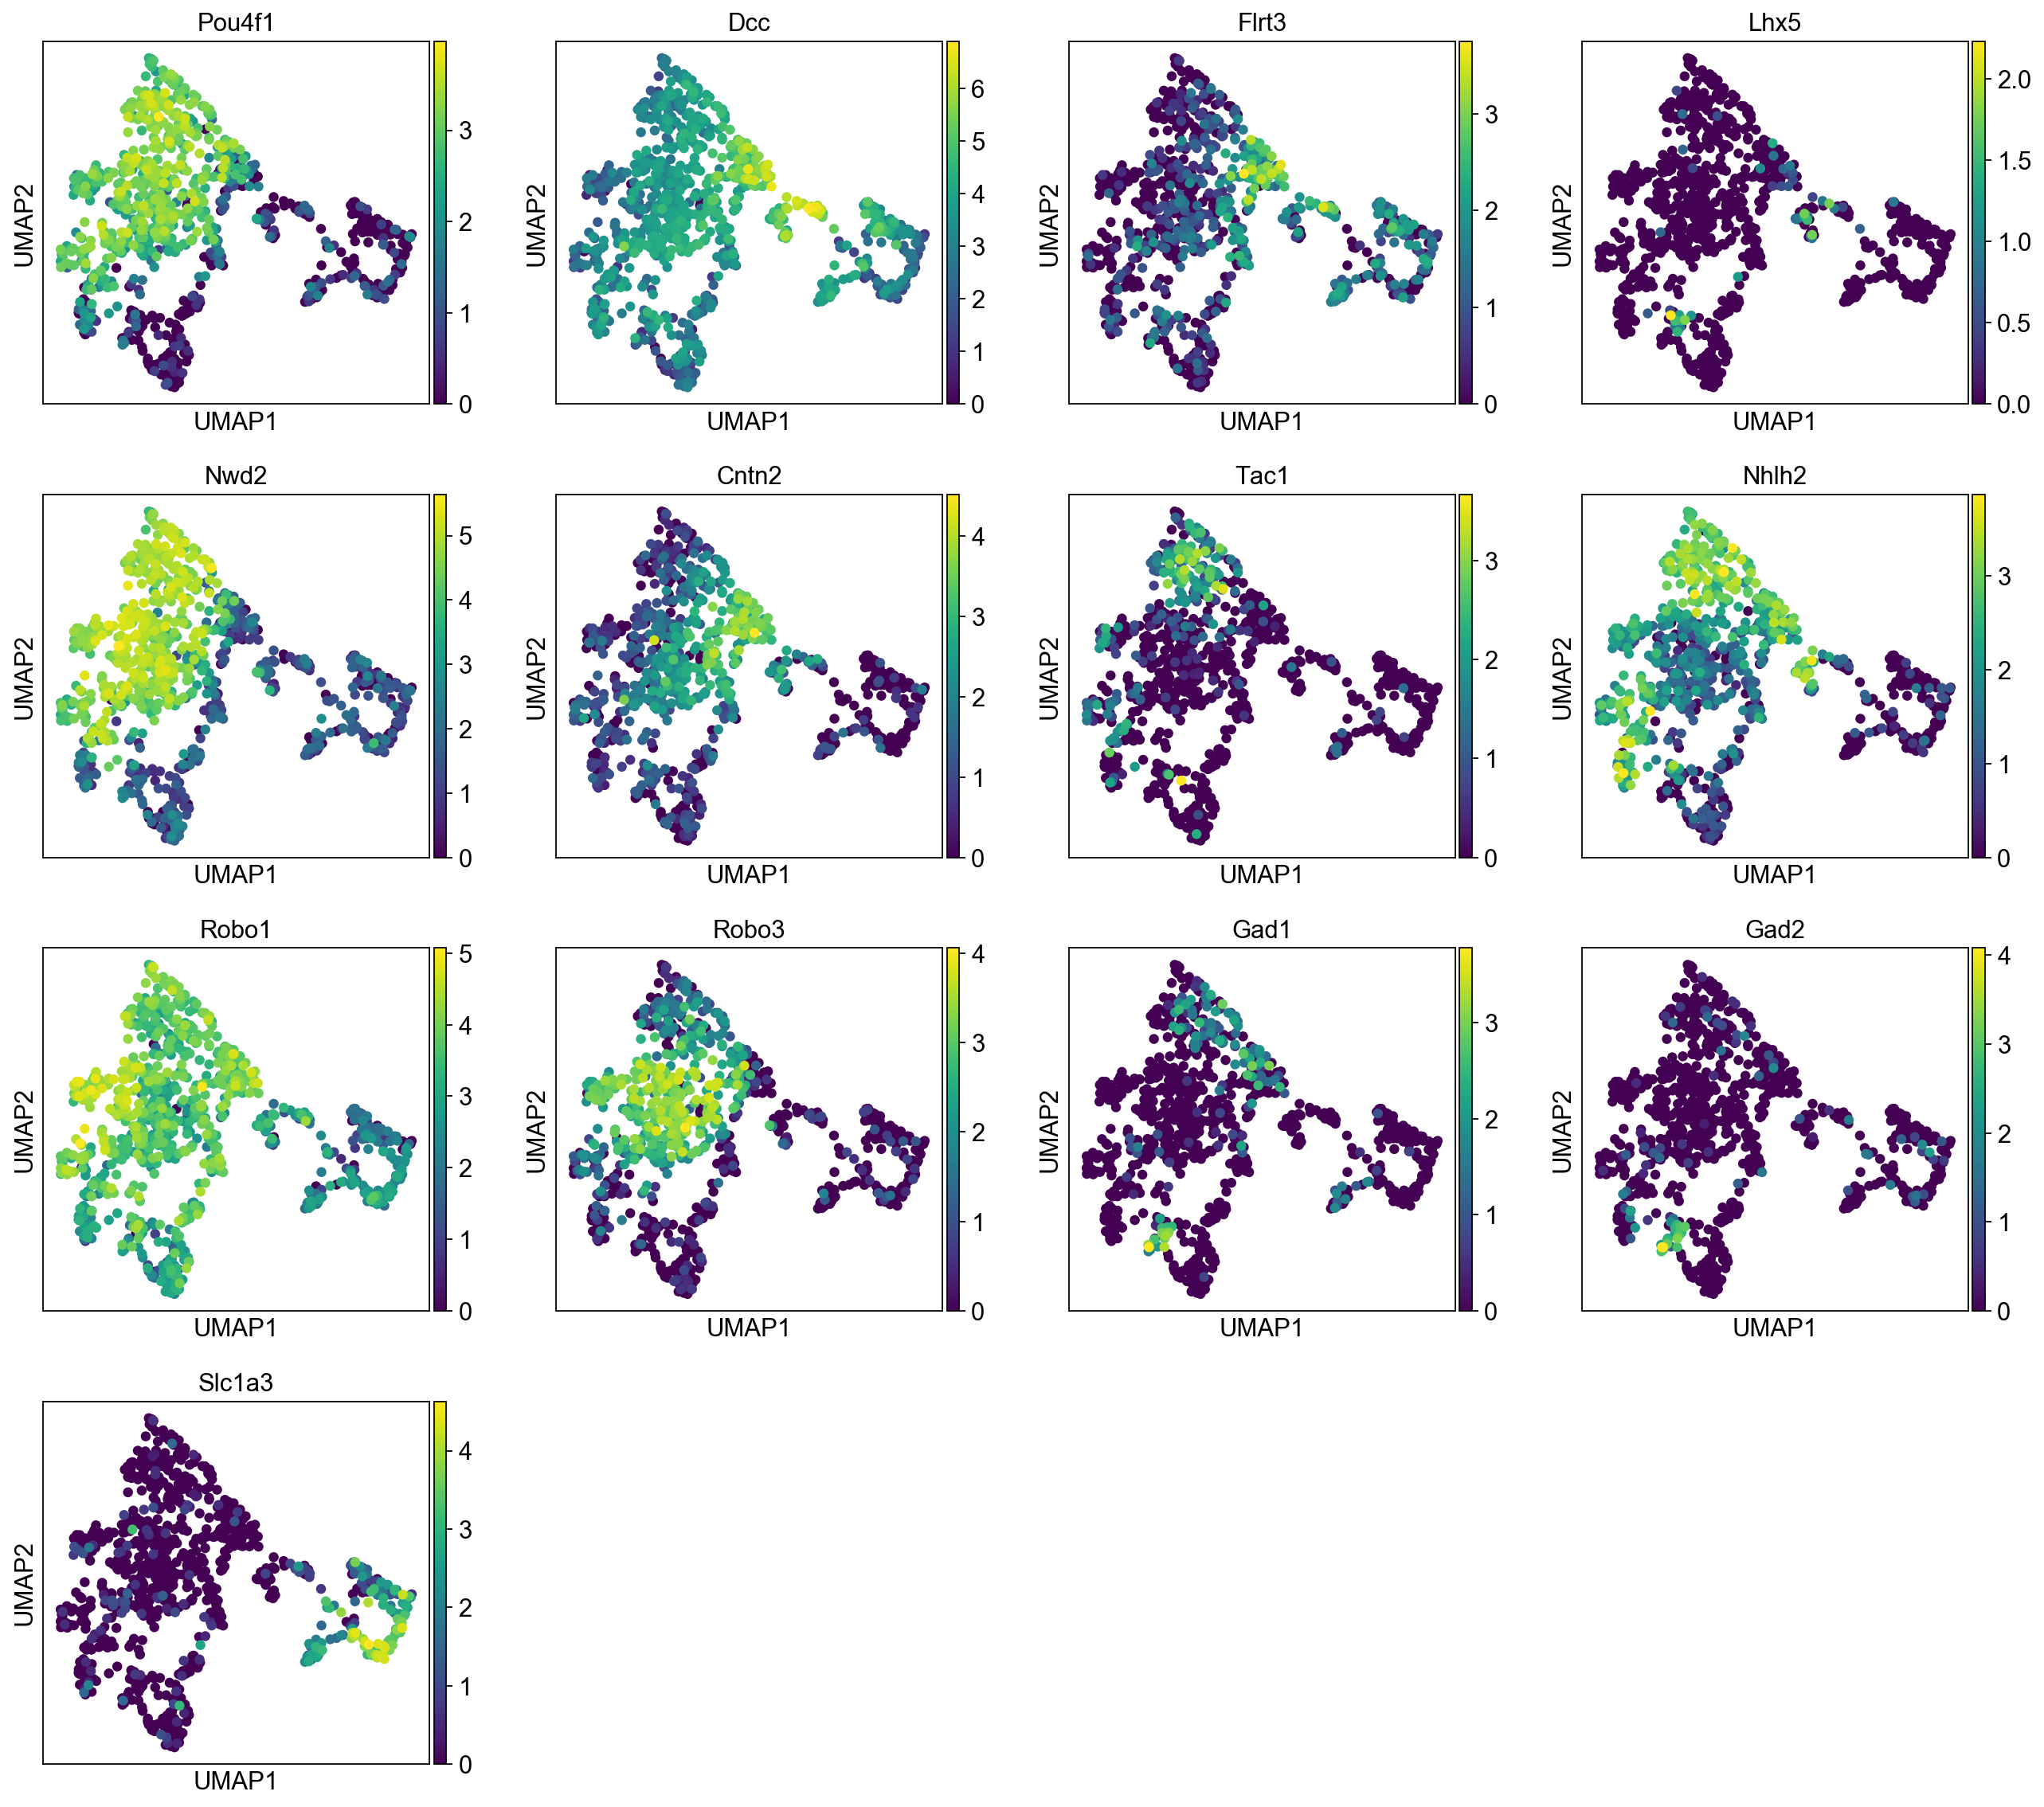

saving figure to file ./figures/umap_umap_stage_plate.pdf


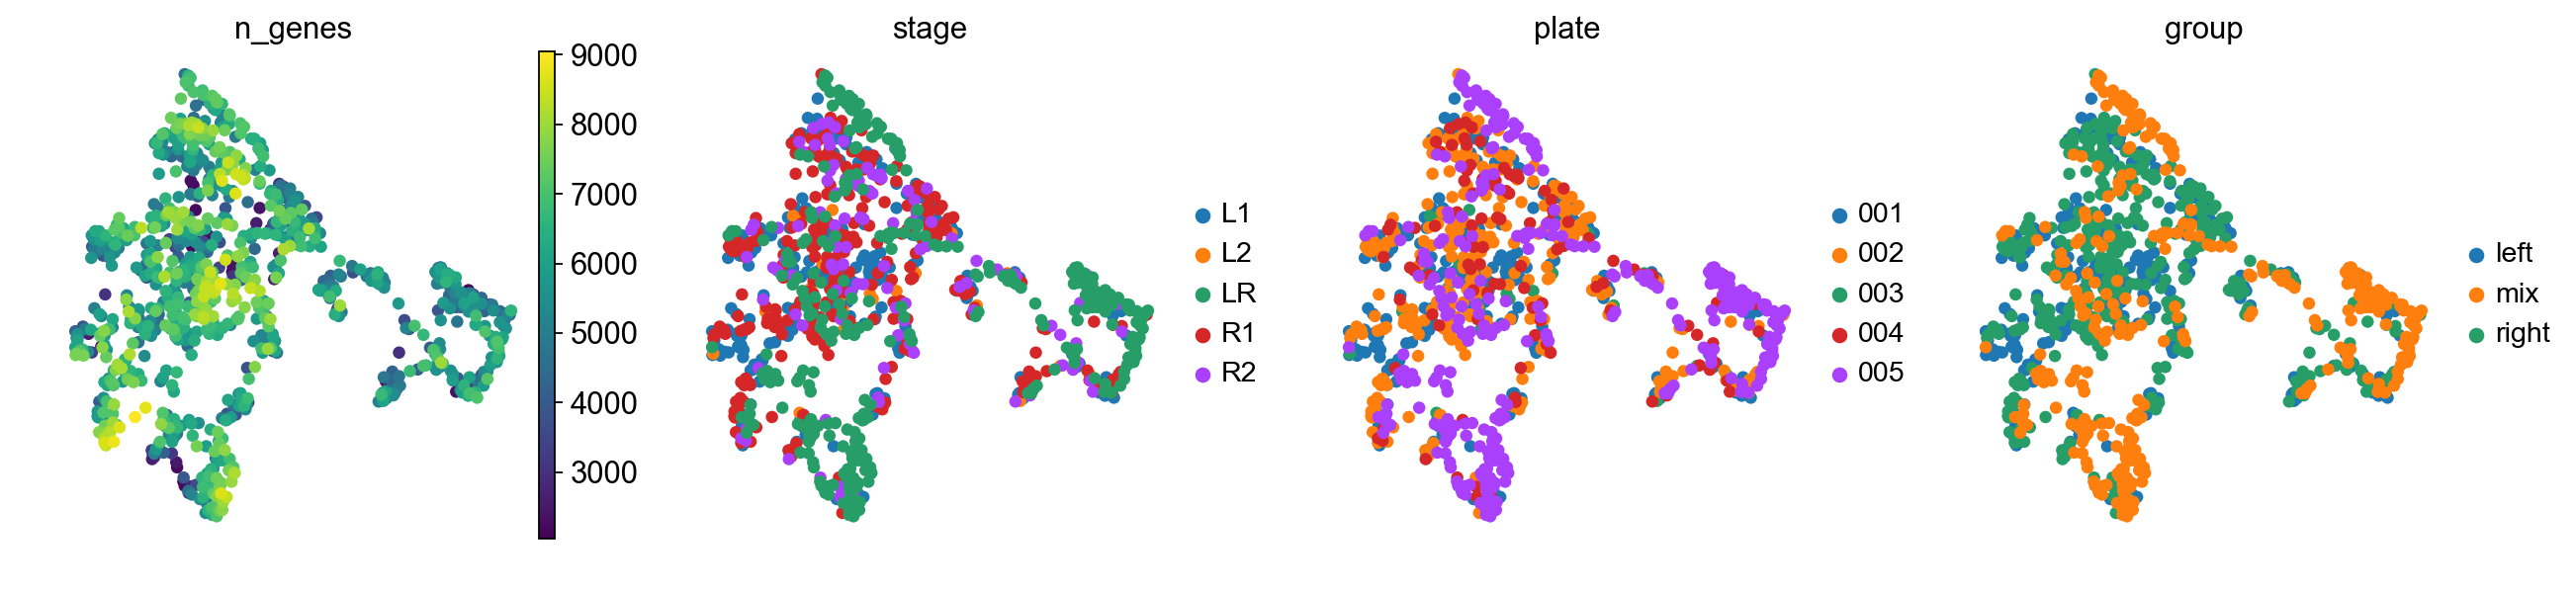

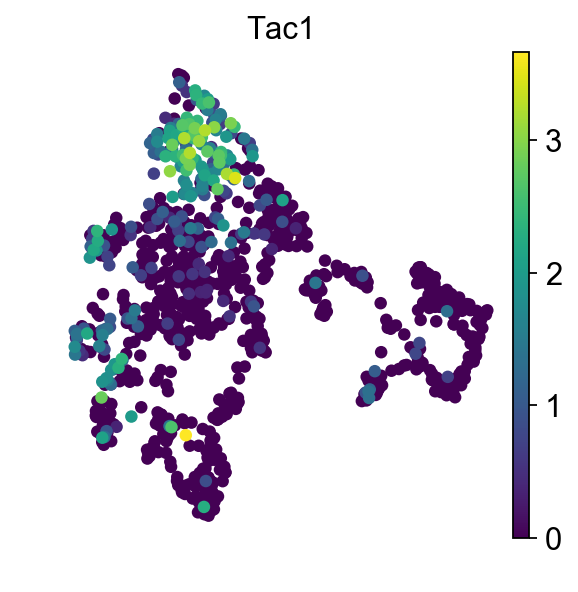

In [64]:
sc.pl.umap(adata, color=['n_genes','Actb','plate', 'stage'], use_raw=True, save = "_umap_plate_stage.pdf")#_bknnbatchcor_withplate_
sc.pl.umap(adata, color=['Pou4f1','Dcc','Flrt3','Lhx5',
                         'Nwd2','Cntn2','Tac1','Nhlh2',
                         'Robo1','Robo3','Gad1','Gad2', 'Slc1a3'], use_raw=True, save = "__umap_markers.pdf")#_bknnbatchcor_withplate_
sc.pl.umap(adata, color=['n_genes','stage', 'plate', 'group'], use_raw=True, frameon=False,save="_umap_stage_plate.pdf")
sc.pl.umap(adata, color=['Tac1'], use_raw=True, frameon=False)


## Clustering the neighborhood graph

In [13]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.24) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


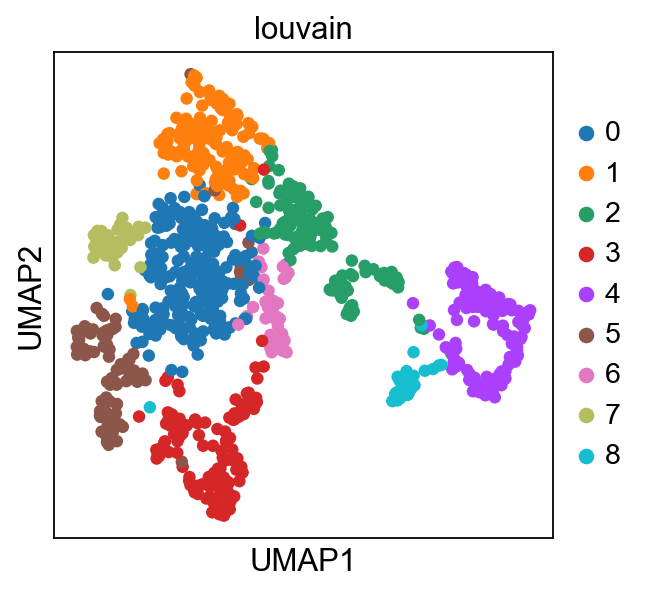

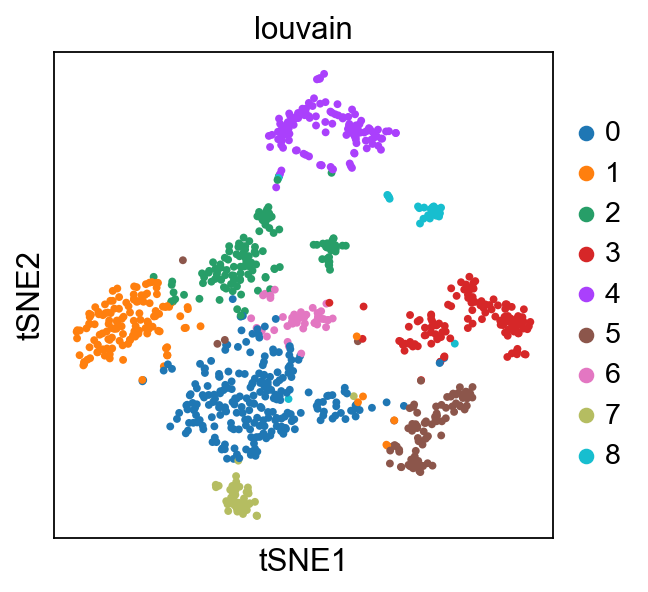

In [14]:
sc.pl.umap(adata, color=['louvain'])

In [76]:
#adata.write('./data/output/April2020_E18Hb-WT_quality_filtered_filtered.h5ad')

In [26]:
adata = sc.read('./data/output/April2020_E18Hb-WT_quality_filtered_filtered.h5ad')

## Export to create Seurat object

In [20]:
adata.obs.to_csv("./data/output/E18WT_metadata.csv")
pd.DataFrame(adata_raw.X, index=adata_raw.obs_names, columns=adata_raw.var_names).to_csv("./data/output/E18WT_rawexpr.csv")